# PixelCNN

На этом семинаре мы познакомимся c PixelCNN — генеративной авторегрессионной модели для изображений, ее обучению и улучшениям, представленным в PixelCNN++. Мы сосредоточимся на применении к датасету MNIST.

In [1]:
# Импортируем необходимые библиотеки

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import uuid
from tqdm import tqdm
from torchvision.utils import make_grid
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os


In [2]:
# check available device
if torch.cuda.is_available():
    device = 'cuda'
else:
    device='cpu'

import warnings
warnings.filterwarnings('ignore')


## Датасет

In [3]:
def load_data(
    dataset_name, # mnist or fashion mnist
    mode, # binary or grayscale
    batch_size: int = 64
):
    """
    Подготавливает DataLoader для MNIST или FashionMNIST в бинаризированном
    или grayscale-режиме.

    Args:
        dataset_name: 'mnist' или 'fashion'.
        mode: 'binary' или 'grayscale'.
        batch_size: Размер батча.

    """

    if mode == 'binary':
        data_transform = transforms.Compose([
            transforms.ToTensor(), # [0.0, 1.0] float
            transforms.Lambda(lambda x: (x > 0.5).float()) # Binarize
        ])


    elif mode == 'grayscale':
        data_transform = transforms.Compose([
            transforms.ToTensor(), # [0.0, 1.0] float
        ])


    else:
        raise ValueError("Режим должен быть 'binary' или 'grayscale'.")

    if dataset_name == 'mnist':
        Dataset = datasets.MNIST
    elif dataset_name == 'fashion':
        Dataset = datasets.FashionMNIST
    else:
        raise ValueError("Имя датасета должно быть 'mnist' или 'fashion'.")

    train_dataset = Dataset(
        root='./data',
        train=True,
        download=True,
        transform=data_transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )


    return train_dataset, train_loader


### Binary mnist

In [4]:
# for binary mnist
train_dataset, train_loader = load_data(
    dataset_name='mnist',
    mode='binary',
    batch_size=512
)

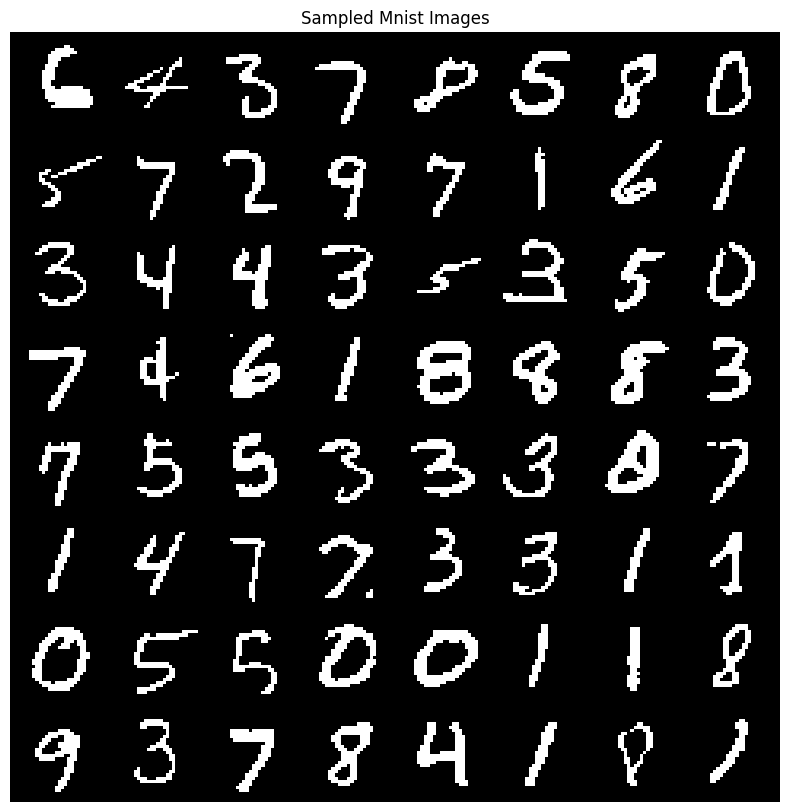

In [5]:
# Посмотрим на один батч изображений
data_iter = iter(train_loader)
images, _ = next(data_iter)

grid = make_grid(images[:64], nrow=8)
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title('Sampled Mnist Images')
plt.show()

In [6]:
# посмотрим на размер картинки, а также на значения
print(f"Разрешение картинок: {images.shape[2:]}")
print(f"Тип данных: {images.dtype}")
print(f"Минимальное значение: {images.min().item()}")
print(f"Максимальное значение: {images.max().item()}")

# Проверка уникальных значений для бинаризированного режима
unique_values = torch.unique(images)
print(f"Уникальные значения: {unique_values}") # как думаете, какие значения ожидаются для бинаризированных картинок?

Разрешение картинок: torch.Size([28, 28])
Тип данных: torch.float32
Минимальное значение: 0.0
Максимальное значение: 1.0
Уникальные значения: tensor([0., 1.])


### Grayscale mnist

In [7]:
# for grayscale mnist
train_dataset_gray, train_loader_gray = load_data(
    dataset_name='mnist',
    mode='grayscale',
    batch_size=128
)

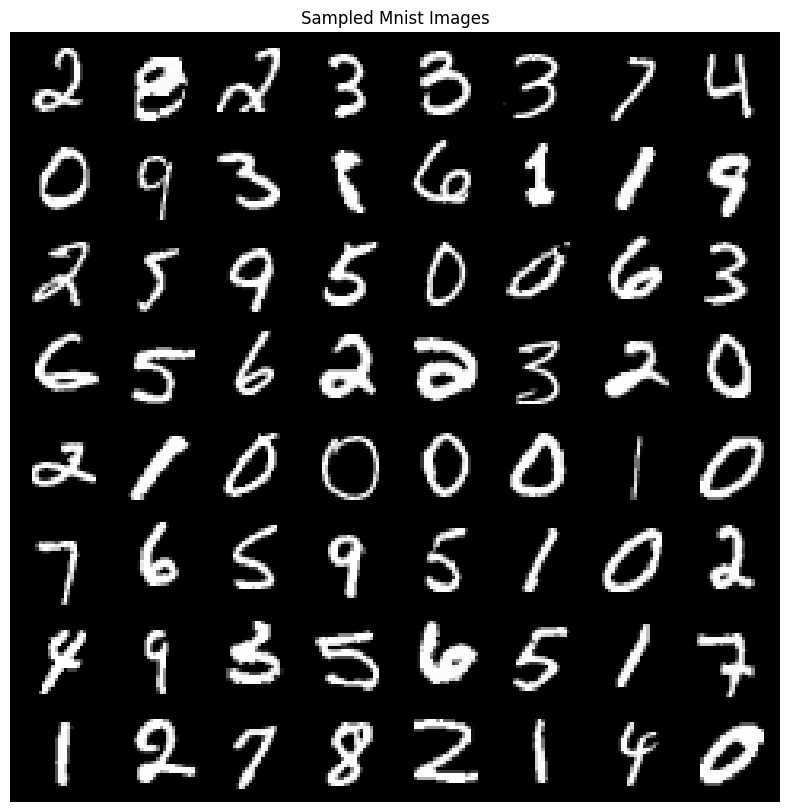

In [8]:

# Посмотрим на один батч изображений
data_iter = iter(train_loader_gray)
images, _ = next(data_iter)

grid = make_grid(images[:64], nrow=8)
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title('Sampled Mnist Images')
plt.show()

In [9]:
# посмотрим на размер картинки, а также на значения
print(f"Разрешение картинок: {images.shape[2:]}")
print(f"Тип данных: {images.dtype}")
print(f"Минимальное значение: {images.min().item()}")
print(f"Максимальное значение: {images.max().item()}")

# Проверка уникальных значений для бинаризированного режима
unique_values = torch.unique(images)
print(f"Уникальные значения: {unique_values}") # как думаете, какие значения ожидаются для бинаризированных картинок?

Разрешение картинок: torch.Size([28, 28])
Тип данных: torch.float32
Минимальное значение: 0.0
Максимальное значение: 1.0
Уникальные значения: tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.

## Авторегрессионная модель

Напомним нашу основную задачу. Мы хотим построить авторегрессионную модель, которая моделирует распределение данных, вычисляя условную вероятность каждого пикселя, основываясь на ранее сгенерированных пикселях.

Для изображения $x$, состоящего из $n \times n$ пикселей, его полная вероятность $p(x)$ может быть разложена на произведение условных вероятностей. Этот процесс называется факторизацией правдоподобия (**Likelihood factorization**).

Пусть $x \sim p(x∣ \theta)$, где $x \in \mathbb{R}^{n \times n}$ и $\theta$ — параметры модели.

Мы можем выразить логарифм правдоподобия всего изображения следующим образом:

$$\log p(\mathbf{x} \mid \theta) = \sum_{j=1}^{n^2} \log p(x_j \mid \mathbf{x}_{1:j-1}, \theta)$$

Здесь $x_j$ — это j-й пиксель в последовательности, а $x_{1:j−1}$ — это вектор всех пикселей, которые ему предшествуют. Эта формула показывает, что общее правдоподобие изображения равно сумме логарифмов правдоподобия каждого пикселя, обусловленного всеми предыдущими. Это и есть основа обучения авторегрессионных моделей методом максимального правдоподобия (MLE).

### Процесс генерации

Генерация нового изображения с помощью обученной авторегрессионной модели — это последовательный процесс, который зеркально отражает процесс обучения. Мы генерируем изображение пиксель за пикселем, используя предсказания модели.

**Шаг 1:** сэмплируем (генерируем) первый пиксель $\hat{x}_1$ из безусловного распределения, предсказанного моделью: $$\hat{x}_1 \sim p(x_1|\theta)$$

**Шаг 2:** используя сгенерированный $\hat{x}_1$, сэмплируем второй пиксель $\hat{x}_2$ из условного распределения:

$$\hat{x}_2 \sim p(x_2|\hat{x}_1, \theta)$$

$$\cdots$$


**Шаг $n^2$**: Продолжаем этот процесс до последнего пикселя. Сэмплируем $\hat{x}_{n^2}$ из условного распределения, обусловленного всеми предыдущими сгенерированными пикселями:

$$\hat{x}_{n^2} \sim p(x_{n^2}|\hat{x}_{1:n^2-1}, \theta)$$



### [PixelRNN](https://arxiv.org/abs/1601.06759)

Давайте кратко вспомним, что такое RNN.

- На каждом шаге $t$, RNN принимает вход $x_t$ и скрытое состояние $h_{t-1}$ (память о прошлом).

$$h_t = f_W(h_{t-1}, x_t)$$

- На выходе она выдает новое скрытое состояние $h_t$ и предсказание $y_t$.


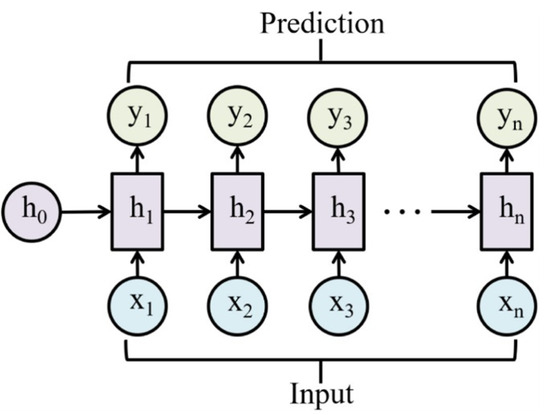

В PixelRNN используется схожая идея:

- На шаге $(i, j)$ модель предсказывает распределение пикселя $x_{i, j}$  на основе скрытого состояния $h_{i, j-1}$, которое суммирует информацию обо всех предыдущих пикселях.

- Сэмплирование обязательно происходит последовательно. Модель должна подождать, пока будет сгенерирован пиксель $x_{i, j-1}$, чтобы использовать его как вход и обновить скрытое состояние для предсказания $x_{i, j}$.

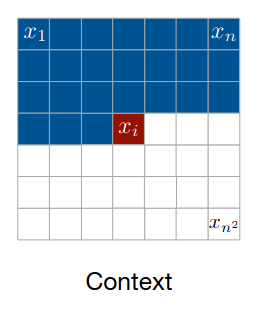

### PixelCNN

PixelRNN обладает очень большим недостатоком, а именно имеет очень низкую скорость. RNN-слои обрабатывают пиксели последовательно, что делает очень долгим процесс не только генерации, но еще и обучения.

Решением этой проблемы стал переход к свёрточной нейросети -- [PixelCNN](https://arxiv.org/pdf/1601.06759.pdf).

Давайте рассмотрим основную идею данного подхода

### Convolution -- напоминание

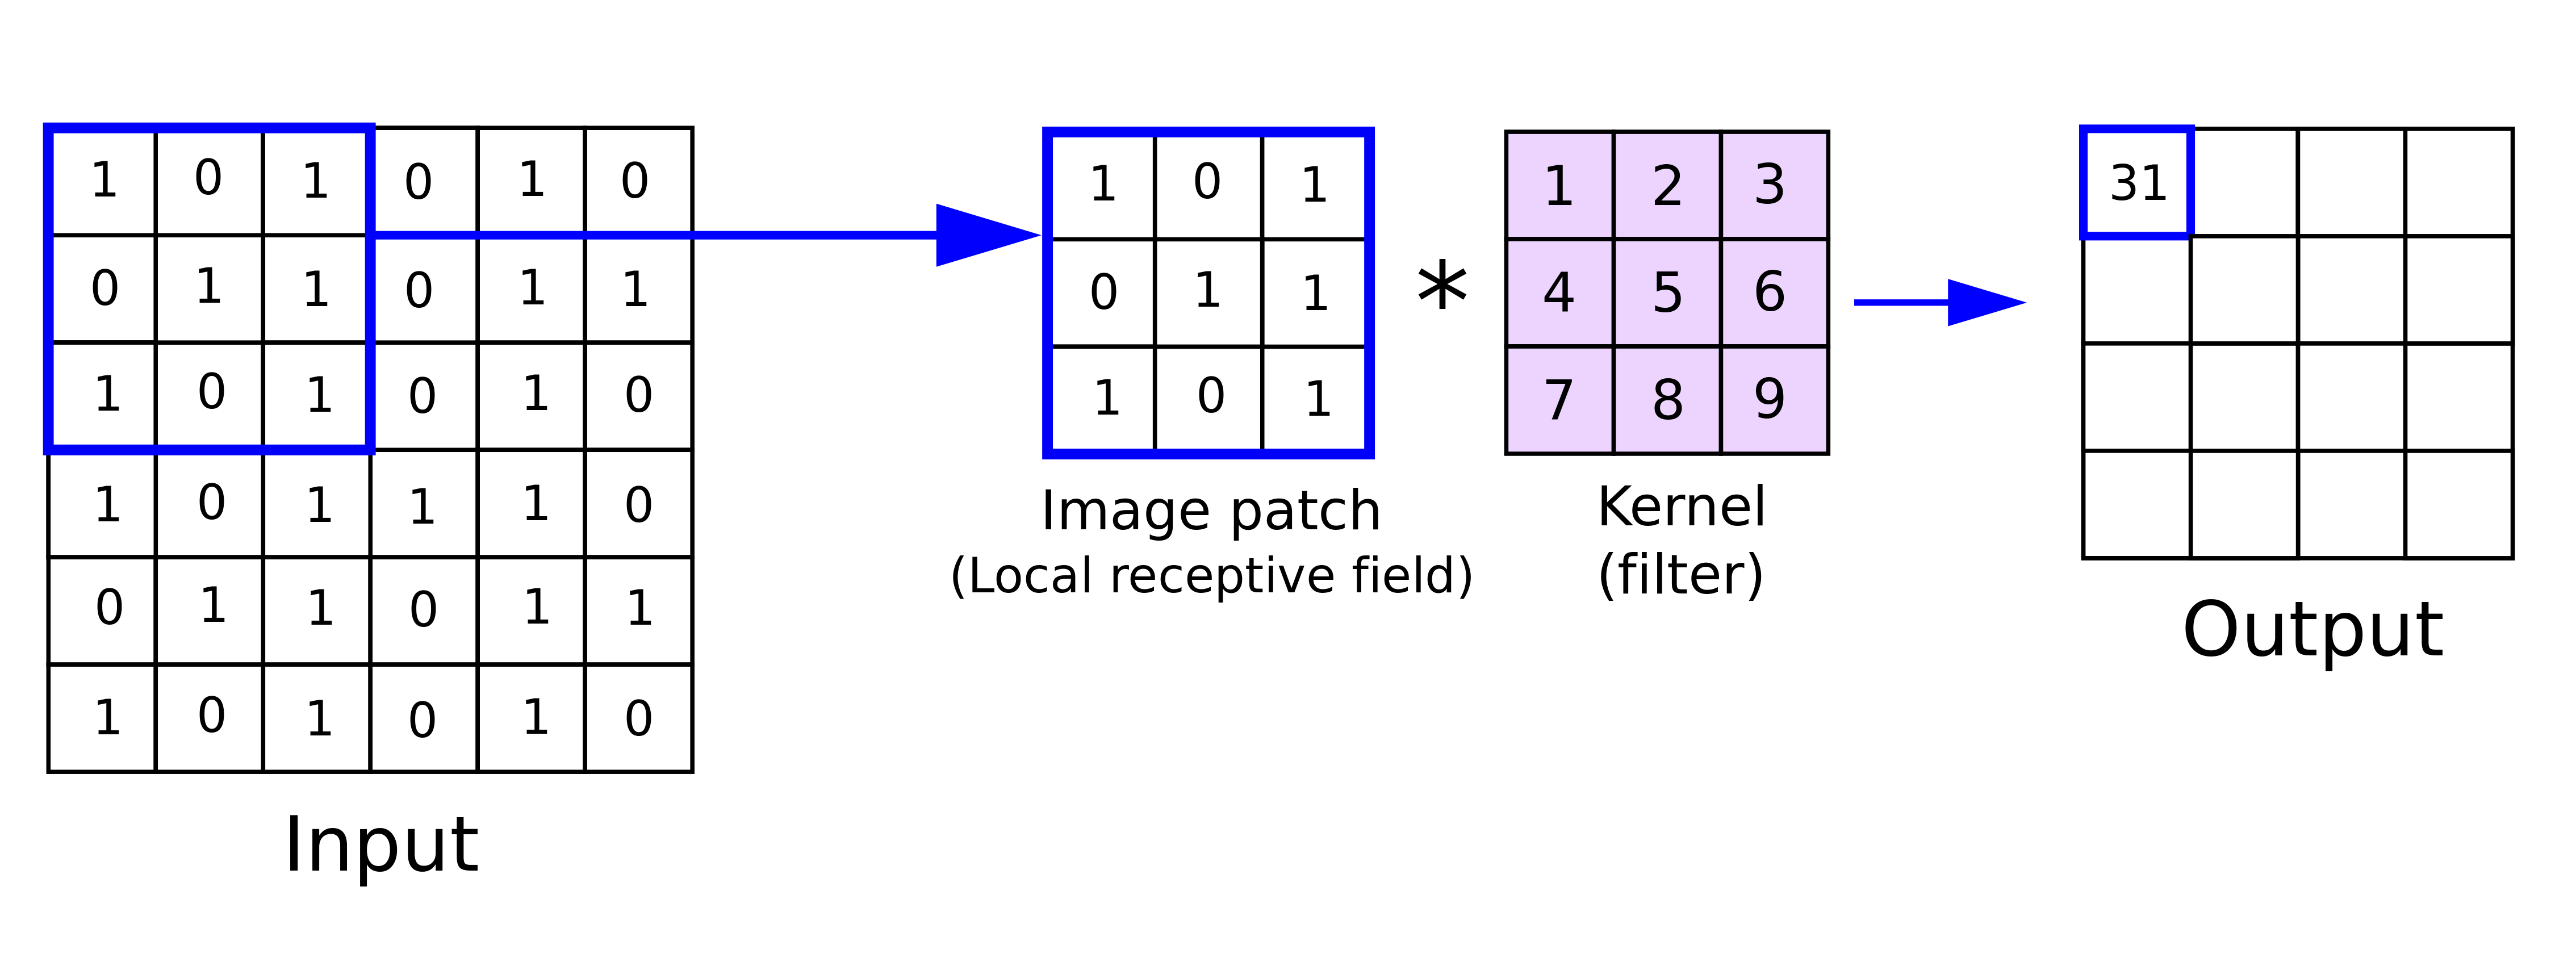

**Вопрос:**

- Какие параметры есть у свёрточного слоя?

- Как рассчитать выход свёрточного слоя?

- Как свёрточный слой работает с каналами?

**Ответ:**

- `in_channels`: количество каналов во входном тензоре

- `out_channels`: количество карт признаков, которые будет генерировать слой. Каждый выходной канал создается одним уникальным фильтром

- `kernel_size`: размер скользящего окна

- `stride`: расстояние, на которое ядро перемещается после каждой операции

- `padding`: количество *дополнительных* пикселей, добавляемых по краям входного изображения.

- `dilation`: интервал между точками ядра


Для того, чтобы рассчитать размер выхода:

$$H_{\text{out}} =  \frac{H_{\text{in}} + 2 \times \text{Padding} - \text{Dilation} \times (\text{Kernel Size} - 1) - 1}{\text{Stride}}  + 1$$

$$W_{\text{out}} =  \frac{W_{\text{in}} + 2 \times \text{Padding} - \text{Dilation} \times (\text{Kernel Size} - 1) - 1}{\text{Stride}} + 1$$



Мы видим, что обычный свёрточный слой учитывает все пиксели вокруг заданного. Однако в случае построения авторегрессионной модели нам надо, чтобы пиксель учитывал только предыдущие. В следующем разделе мы с вами разберёмся, как этого добиться.

### Masked convolution


**Masked Convolution** -- это модификация стандартной свёрточной операции, которая ограничивает receptive field таким образом, чтобы при вычислении значения текущего пикселя модель "видела" только те пиксели, которые предшествуют ему в определенной последовательности.

Маскирование достигается путем умножения весов свёрточного ядра на бинарную маску. Эта маска имеет значения $0$ и $1$:

1 — для пикселей, которые модель может видет (включая или исключая центральный пиксель).

0 — для пикселей, которые модель не может видеть.

**Маска А**

Используется **только в самом первом** свёрточном слое. Она позволяет свёртке "видеть" все пиксели **выше** и **левее** текущего пикселя, но НЕ сам текущий пиксель и все, что правее и ниже.

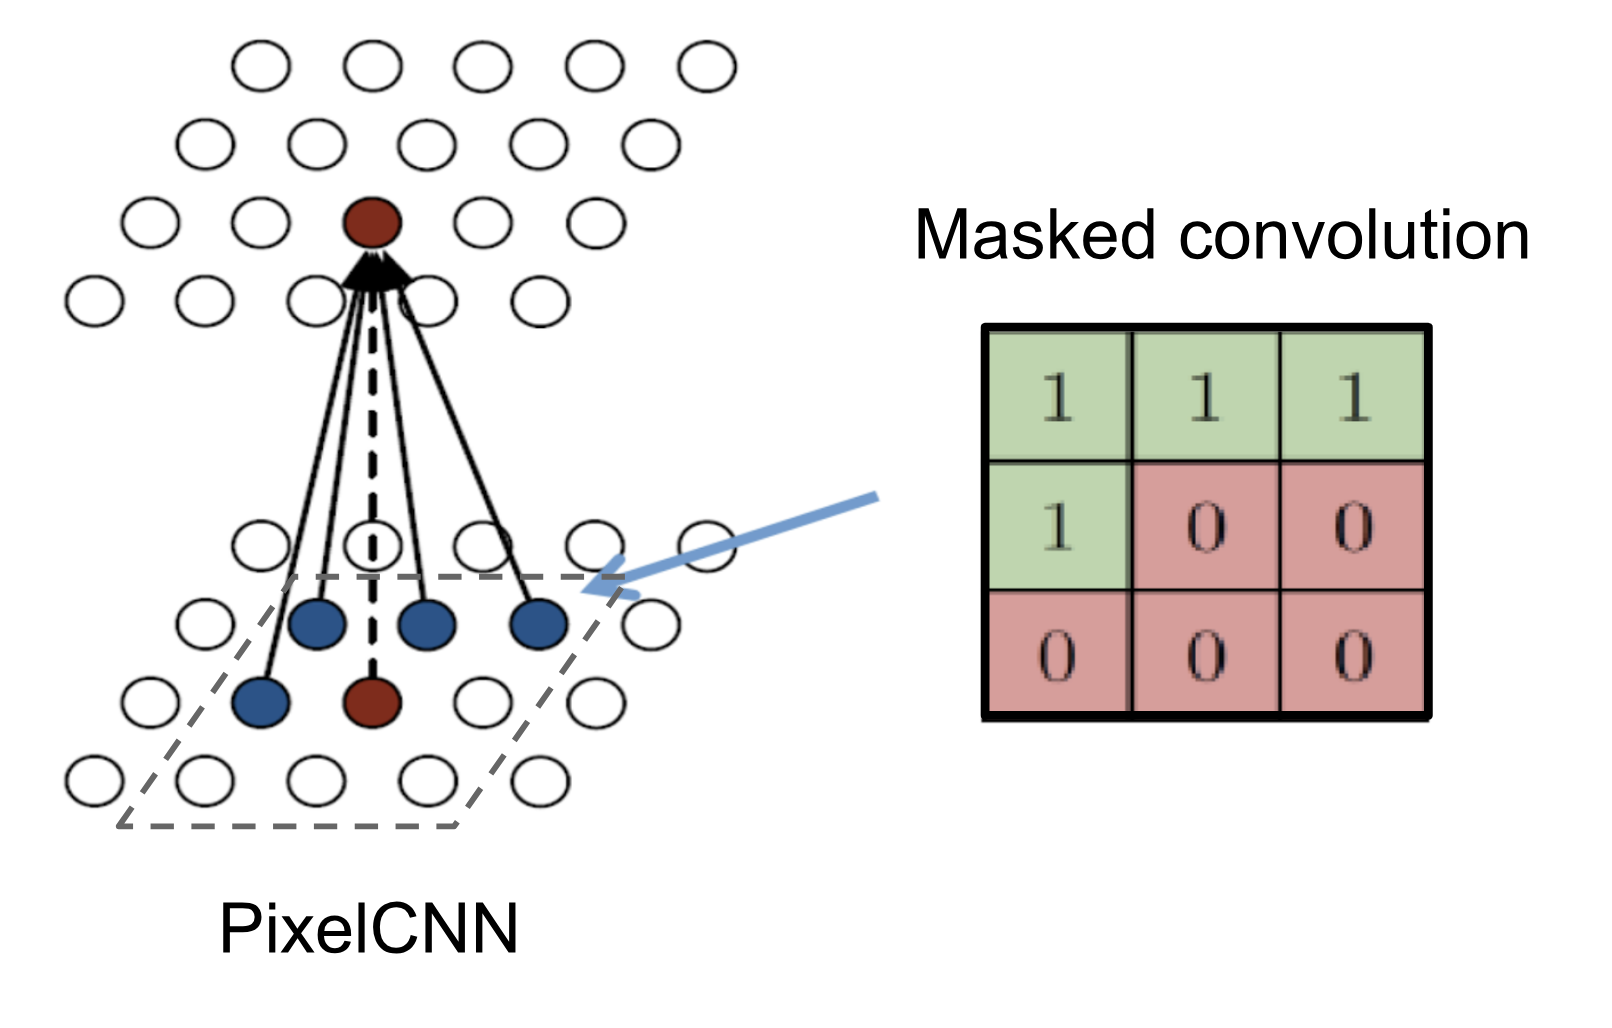

**Маска В**

Используется во всех последующих свёрточных слоях. Она позволяет свёртке "видеть" все пиксели **выше**, **левее**, и **САМ центральный пиксель**.

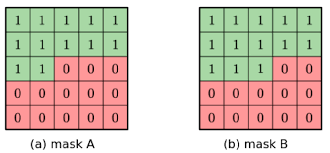

Давайте реализуем masked convolution.

In [10]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int = 5,
                 padding: int=1):
        """
        Реализация маскированной 2D свёртки.

        Args:
            mask_type (str): Тип маски ('A' или 'B').
        """
        assert mask_type in ["A", "B"]
        super().__init__(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         padding=kernel_size // 2)

        # Подумайте, почему мы делаем регистрацию буффера?
        self.register_buffer('mask', self.weight.data.clone())

        # Создание маски
        _, _, h, w = self.weight.size()
        self.mask.fill_(1)

        # Центр ядра
        center_h, center_w = h // 2, w // 2

        # Правило для маски 'A':
        if mask_type == 'A':
            # Скрываем всё справа от центра на центральной строке
            self.mask[:, :, center_h, center_w + 1:] = 0
            # Скрываем всю нижнюю половину
            self.mask[:, :, center_h + 1:, :] = 0
            # Скрываем сам центральный пиксель
            self.mask[:, :, center_h, center_w] = 0

        # Правило для маски 'B':
        else: # mask_type == 'B'
            # Скрываем всё справа от центра на центральной строке
            self.mask[:, :, center_h, center_w + 1:] = 0
            # Скрываем всю нижнюю половину
            self.mask[:, :, center_h + 1:, :] = 0

    def forward(self, x):
        # Применяем маску к весам перед прямым проходом
        return F.conv2d(x, self.weight * self.mask, self.bias, padding=self.padding)



In [11]:
# Проверка маски типа A 3x3
conv_A_test = MaskedConv2d('A', in_channels=1, out_channels=1, kernel_size=3)
mask_A_expected = torch.tensor([
    [1., 1., 1.],
    [1., 0., 0.],
    [0., 0., 0.]
])

try:
    assert torch.equal(conv_A_test.mask[0, 0].cpu(), mask_A_expected), "Ошибка в логике Маски Типа A!"
    print("Проверка Маски Типа A (3x3): УСПЕШНО")
except AssertionError as e:
    print(f"!!! {e}")
    print("Ожидаемая маска A:")
    print(mask_A_expected.int())
    print("Полученная маска A:")
    print(conv_A_test.mask[0, 0].int())


# 2. Проверка маски типа B 3x3
conv_B_test = MaskedConv2d('B', in_channels=1, out_channels=1, kernel_size=3)
mask_B_expected = torch.tensor([
    [1., 1., 1.],
    [1., 1., 0.],
    [0., 0., 0.]
])
try:
    assert torch.equal(conv_B_test.mask[0, 0].cpu(), mask_B_expected), "Ошибка в логике Маски Типа B!"
    print("Проверка Маски Типа B (3x3): УСПЕШНО")
except AssertionError as e:
    print(f"!!! {e}")
    print("Ожидаемая маска B:")
    print(mask_B_expected.int())
    print("Полученная маска B:")
    print(conv_B_test.mask[0, 0].int())

Проверка Маски Типа A (3x3): УСПЕШНО
Проверка Маски Типа B (3x3): УСПЕШНО


Использование двух разных масок критически важно для корректной работы PixelCNN.

Как вы думаете, зачем нам два типа маски и при построении нейросети, в каком случае надо использовать какой тип?






Давайте теперь соберём модель PixelCNN

Но для начала давайте вспомним, что такое `LayerNorm2d`.

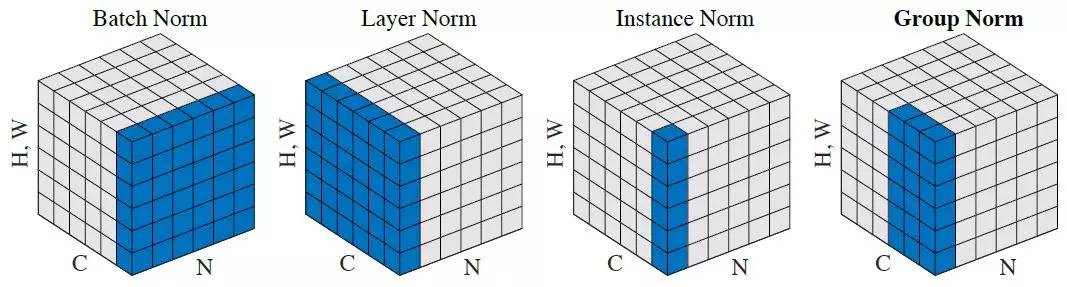

In [12]:
class LayerNorm2d(nn.LayerNorm):
    def __init__(self, n_filters: int) -> None:
        super().__init__(n_filters)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm


class PixelCNN(nn.Module):
    def __init__(self, in_channels=1,
                 out_channels=2,
                 spat_shape=(28, 28),
                 hidden_channels=[64, 64, 64, 64, 64],
                 kernel_size=7,
                 device='cuda'):
        super(PixelCNN, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.spat_shape = spat_shape
        self.device = device
        num_layers = len(hidden_channels)
        self.loss_fn = nn.CrossEntropyLoss()


        model = [MaskedConv2d("A", in_channels=1, out_channels=hidden_channels[0], kernel_size=kernel_size)]

        for in_hid_chan, out_hid_chan in zip(hidden_channels[:-1], hidden_channels[1:]):

            model.append(LayerNorm2d(in_hid_chan))
            model.append(nn.ReLU())
            model.append(
                MaskedConv2d("B", in_channels=in_hid_chan, out_channels=out_hid_chan, kernel_size=kernel_size)
            )

        model.extend(
            [
                nn.ReLU(),
                MaskedConv2d("B", in_channels=hidden_channels[-1], out_channels=out_channels, kernel_size=1),
            ]
        )

        self.net = nn.Sequential(*model)

    def forward(self, x):
        x = (x.float() - 0.5) / 0.5
        x = self.net(x)

        b, c, h, w = x.shape

        return x.view(b, self.out_channels, 1, h, w)

    def sample(self, n: int):

        # Инициализируем пустые сэмплы
        samples = torch.zeros(n, self.in_channels, *self.spat_shape).to(self.device)

        # Последовательность для обхода пикселей (авторегрессия)
        ordering = itertools.product(range(self.spat_shape[0]), range(self.spat_shape[1]))
        normalization_divisor = float(self.out_channels - 1) if self.out_channels > 1 else 1.0

        with torch.no_grad():
            for (r, c) in ordering:

                logits = self(samples)[..., r, c] # (B, K)

                # 2. Вычисление вероятностей
                # Применяем softmax для получения распределения
                probs = F.softmax(logits.squeeze(-1), dim=1) # (B, K)


                # 3. Сэмплирование класса
                # Выбираем один индекс класса (0..K-1) на основе вероятностей
                sampled_class = torch.multinomial(probs, num_samples=1)

                # 4. Обновление изображения
                # Записываем сэмплированный класс (индекс) в текущий пиксель
                #print(normalization_divisor)
                samples[..., r, c] = sampled_class / normalization_divisor


        # 5. Финальная нормализация для выхода [0, 1]
        # Преобразуем Tensor [0, 255] в FloatTensor [0.0, 1.0]
        return samples.cpu().numpy()

Давайте решать задачу для двух ситуаций:

* Binarized MNIST

* Grayscale MNIST

В чем основное отличие между постановками?

Ответье на следующие вопросы:

1. Какое количество каналов должна выдавать сетка для каждого из сценариев?

2. Будут ли как-то отличаться функции потерь?



### Cross entropy loss

В качестве основной функции потерь мы будем использовать [кросс-энтропию](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

#### Вспомогательные функции

In [14]:
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth.tar"):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(state, filename)
    print(f"Веса сохранены: {filename}")

def load_checkpoint(model, optimizer, filename="checkpoint.pth.tar"):
    if os.path.isfile(filename):
        print(f"Загрузка весов '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Загрузка завершена. Эпоха {epoch}, Loss: {loss:.4f}")
        return epoch
    else:
        print(f"Веса '{filename}' не найдены.")
        return 0

In [15]:
def plot_samples(samples_np: np.ndarray, epoch: int, step: int, filepath: str):
    """Визуализирует и сохраняет сгенерированные образцы."""
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.suptitle(f"Epoch {epoch}, Step {step} | Samples (Trained)", fontsize=16)

    for i in range(5):
        for j in range(5):
            idx = i * 5 + j
            if idx < samples_np.shape[0]:
                ax = axes[i, j]
                ax.imshow(samples_np[idx][0], cmap='gray', vmin=0, vmax=1)
                ax.axis('off')
            else:
                axes[i, j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filepath)
    plt.show()
    plt.close(fig)

In [41]:
def train_pixelcnn(model: PixelCNN,
                   train_loader: DataLoader,
                   config,
                   epochs: int = 10,
                   lr: float = 0.001,
                   device='cuda',
                   checkpoint_dir: str = "checkpoints",
                   generated_img_dir: str = "generated_images",
                   generate_every: int = 2000): # Генерировать каждые 2000 шагов

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Создадим директории
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(generated_img_dir, exist_ok=True)

    loss_fn = nn.CrossEntropyLoss()

    loss_history = []

    global_step = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} | {config['mode'].upper()}") as pbar:
            for images, _ in pbar:
                # Target images are LongTensor [0, 1] or [0, 255]
                images = images.to(device)

                # outputs: (B, K, H, W)
                outputs = model(images)


                # 3. Cross Entropy Loss (Universal for K>1)
                if config['mode'] == 'gray':
                    loss = loss_fn(outputs, (images * 255.).long())
                else:
                    loss = loss_fn(outputs, images.long())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                loss_history.append(loss.item())
                pbar.set_postfix(loss=f"{running_loss/(pbar.n+1):.4f}")

                global_step += 1

                # --- Генерация образцов ---
                if global_step % generate_every == 0 and global_step > 0:
                    model.eval()
                    print(f"\n--- Генерируем сэмплы на шаге {global_step}...")

                    # Генерируем 25 образцов
                    samples = model.sample(n=25)


                    # Сохраняем образцы
                    filepath = os.path.join(generated_img_dir,
                                            f"samples_e{epoch+1}_s{global_step}.png")
                    plot_samples(samples, epoch=epoch+1, step=global_step, filepath=filepath)

                    print(f"Сэмплы сохранены в {filepath}")
                    model.train()

        # Сохранение чекпоинта в конце эпохи
        avg_loss = running_loss / len(train_loader)
        save_checkpoint(model, optimizer, epoch, avg_loss,
                        os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth.tar"))

    print("Обучение завершено.")
    return loss_history


####  PixelCNN for binarized MNIST

Давайте посмотрим, что выдаёт наша модель, пока мы ее не обучили.



In [17]:
LR = 1e-3  # < 1e-2
N_LAYERS = 5  # < 10
N_FILTERS = 128  # < 128
USE_LAYER_NORM = True

model_binary = PixelCNN(in_channels=1,
                        out_channels=2,
                        hidden_channels=[N_FILTERS,] * N_LAYERS,
                        kernel_size=5,
                        device=device)

model_binary = model_binary.to(device)

([128, 128, 128, 128, 128],)

In [107]:
model_binary

PixelCNN(
  (loss_fn): CrossEntropyLoss()
  (net): Sequential(
    (0): MaskedConv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaskedConv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): MaskedConv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): MaskedConv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
    (12): MaskedConv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): MaskedConv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [108]:
total_params = sum(p.numel() for p in model_binary.parameters() if p.requires_grad)
print(f"Модель: PixelCNN (бинарная)")
print(f"Общее количество обучаемых параметров: {total_params:,}")


Модель: PixelCNN (бинарная)
Общее количество обучаемых параметров: 1,643,522


In [109]:
samples = model_binary.sample(15)


--- Результаты сэмплирования ---
Форма сэмплов: (15, 1, 28, 28)
Диапазон значений: 0.0 - 1.0


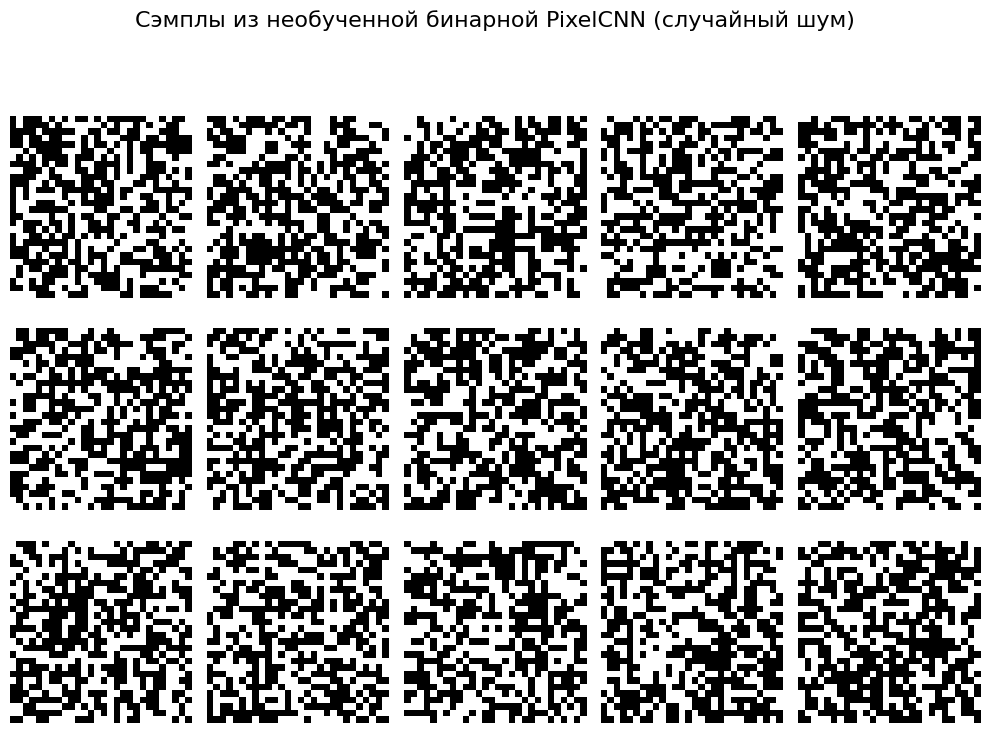

In [97]:
print("\n--- Результаты сэмплирования ---")
print(f"Форма сэмплов: {samples.shape}")
print(f"Диапазон значений: {samples.min()} - {samples.max()}")

# 4. Визуализация
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
fig.suptitle("Сэмплы из необученной бинарной PixelCNN (случайный шум)", fontsize=16)
for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        ax = axes[i, j]
        ax.imshow(samples[idx][0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')

# Уменьшаем отступы между сабплотами для более компактного вида
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Epoch 1/8 | BINARY:  99%|█████████▉| 117/118 [01:50<00:00,  1.06it/s, loss=0.2218]


--- Генерируем сэмплы на шаге 118...


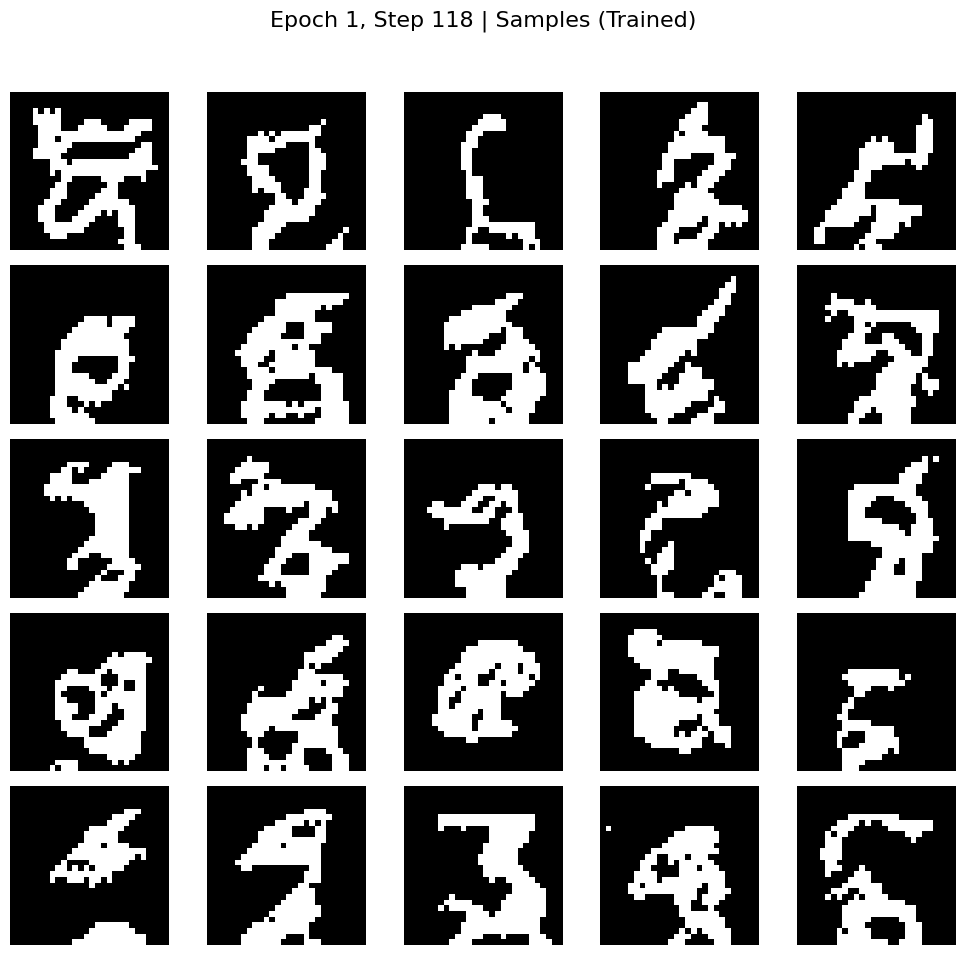

Epoch 1/8 | BINARY: 100%|██████████| 118/118 [01:57<00:00,  1.01it/s, loss=0.2218]


Сэмплы сохранены в generated_images/samples_e1_s118.png
Веса сохранены: checkpoints/checkpoint_epoch_1.pth.tar


Epoch 2/8 | BINARY:  99%|█████████▉| 117/118 [01:50<00:00,  1.05it/s, loss=0.0982]


--- Генерируем сэмплы на шаге 236...


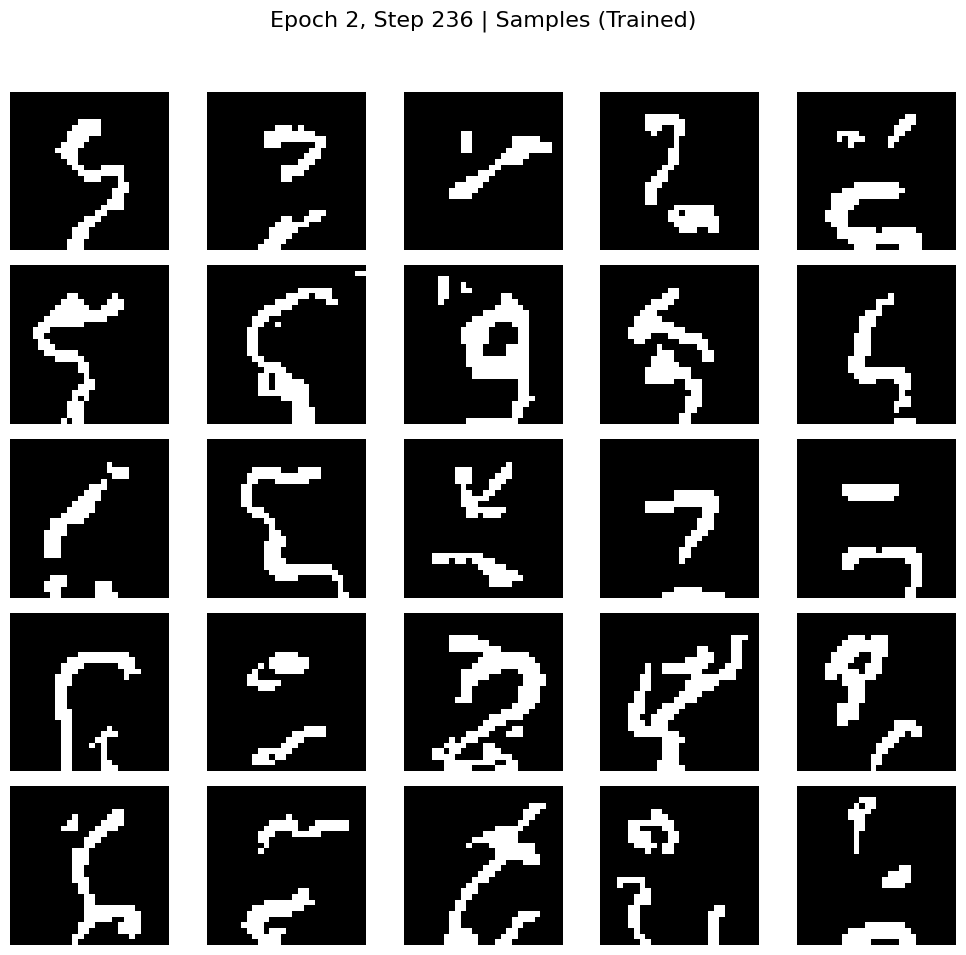

Epoch 2/8 | BINARY: 100%|██████████| 118/118 [01:57<00:00,  1.00it/s, loss=0.0982]


Сэмплы сохранены в generated_images/samples_e2_s236.png
Веса сохранены: checkpoints/checkpoint_epoch_2.pth.tar


Epoch 3/8 | BINARY:  99%|█████████▉| 117/118 [01:50<00:00,  1.06it/s, loss=0.0913]


--- Генерируем сэмплы на шаге 354...


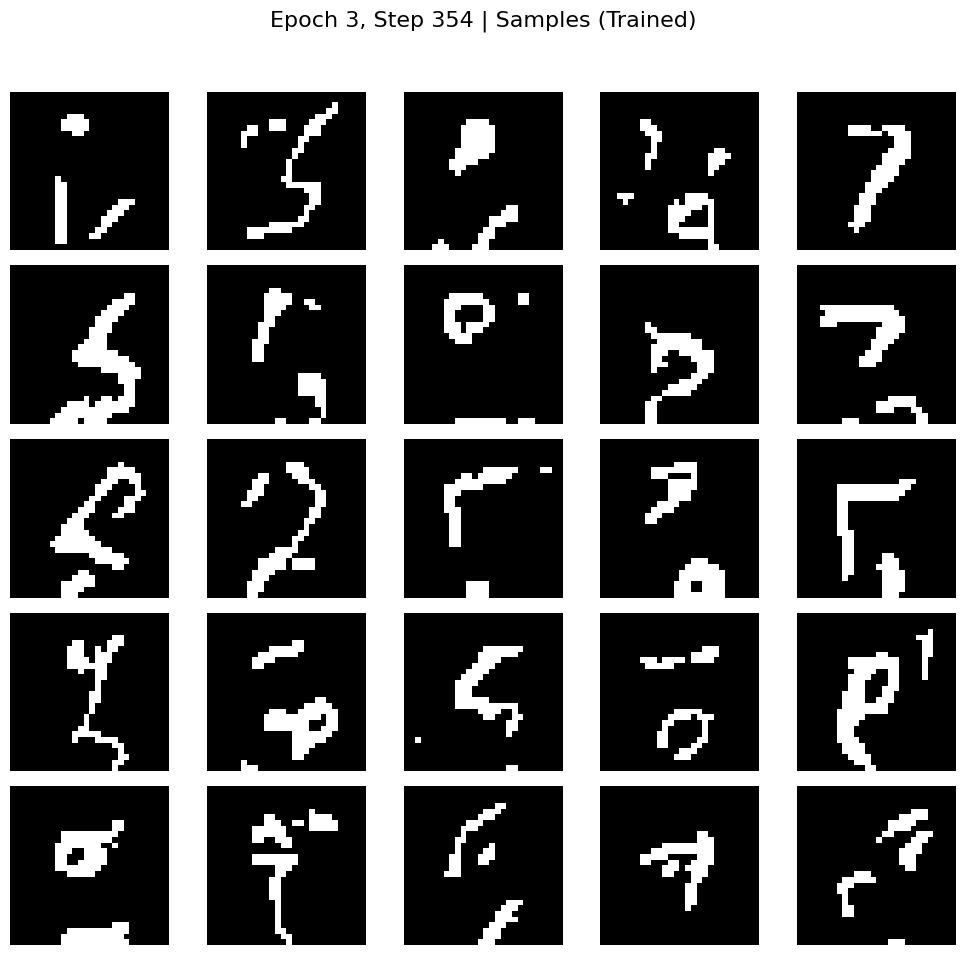

Epoch 3/8 | BINARY: 100%|██████████| 118/118 [01:58<00:00,  1.00s/it, loss=0.0913]


Сэмплы сохранены в generated_images/samples_e3_s354.png
Веса сохранены: checkpoints/checkpoint_epoch_3.pth.tar


Epoch 4/8 | BINARY:  99%|█████████▉| 117/118 [01:52<00:01,  1.00s/it, loss=0.0889]


--- Генерируем сэмплы на шаге 472...


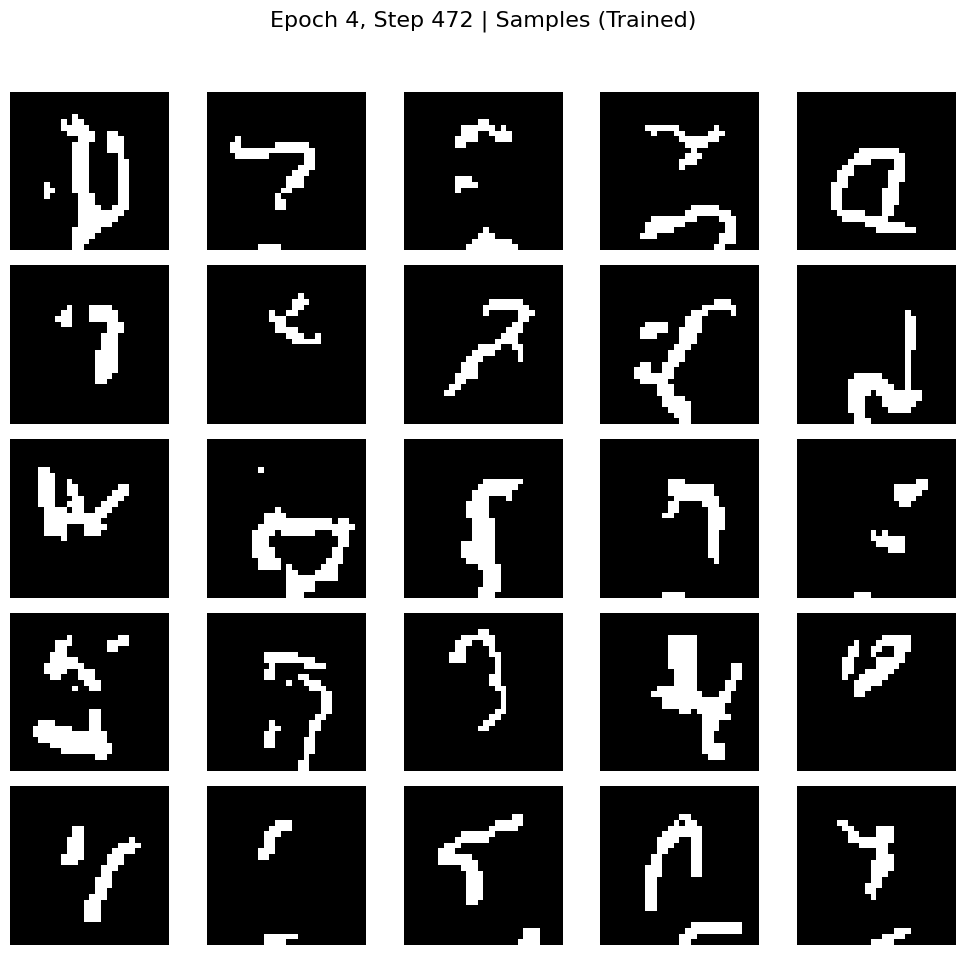

Epoch 4/8 | BINARY: 100%|██████████| 118/118 [01:59<00:00,  1.01s/it, loss=0.0889]


Сэмплы сохранены в generated_images/samples_e4_s472.png
Веса сохранены: checkpoints/checkpoint_epoch_4.pth.tar


Epoch 5/8 | BINARY:  99%|█████████▉| 117/118 [01:51<00:00,  1.05it/s, loss=0.0875]


--- Генерируем сэмплы на шаге 590...


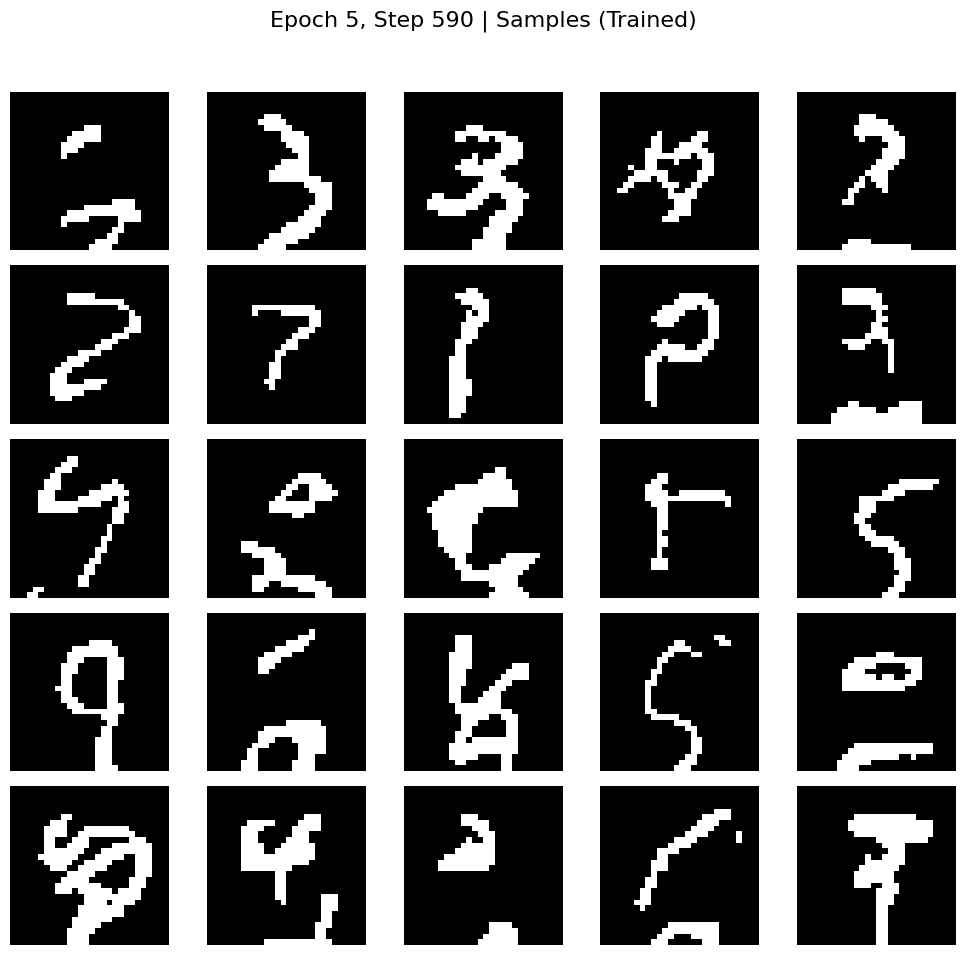

Epoch 5/8 | BINARY: 100%|██████████| 118/118 [01:58<00:00,  1.00s/it, loss=0.0875]


Сэмплы сохранены в generated_images/samples_e5_s590.png
Веса сохранены: checkpoints/checkpoint_epoch_5.pth.tar


Epoch 6/8 | BINARY:  99%|█████████▉| 117/118 [01:51<00:00,  1.06it/s, loss=0.0864]


--- Генерируем сэмплы на шаге 708...


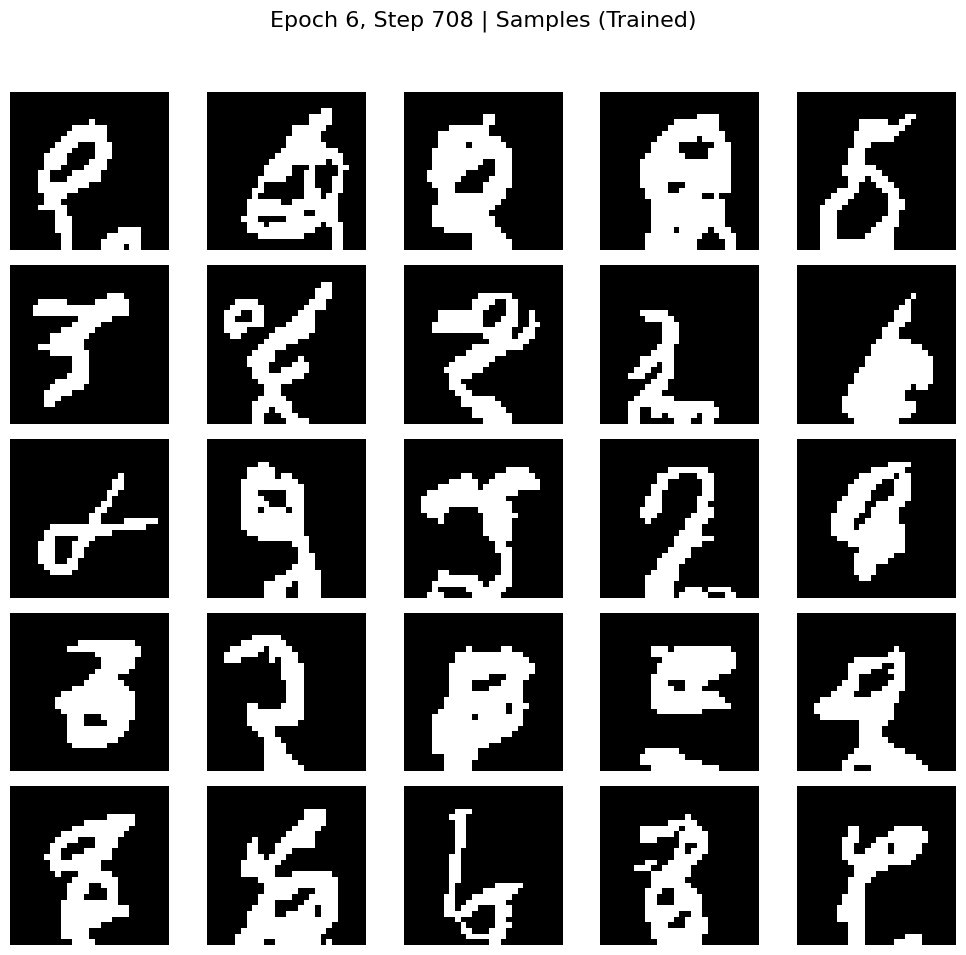

Epoch 6/8 | BINARY: 100%|██████████| 118/118 [01:57<00:00,  1.00it/s, loss=0.0864]


Сэмплы сохранены в generated_images/samples_e6_s708.png
Веса сохранены: checkpoints/checkpoint_epoch_6.pth.tar


Epoch 7/8 | BINARY:  99%|█████████▉| 117/118 [01:51<00:00,  1.05it/s, loss=0.0857]


--- Генерируем сэмплы на шаге 826...


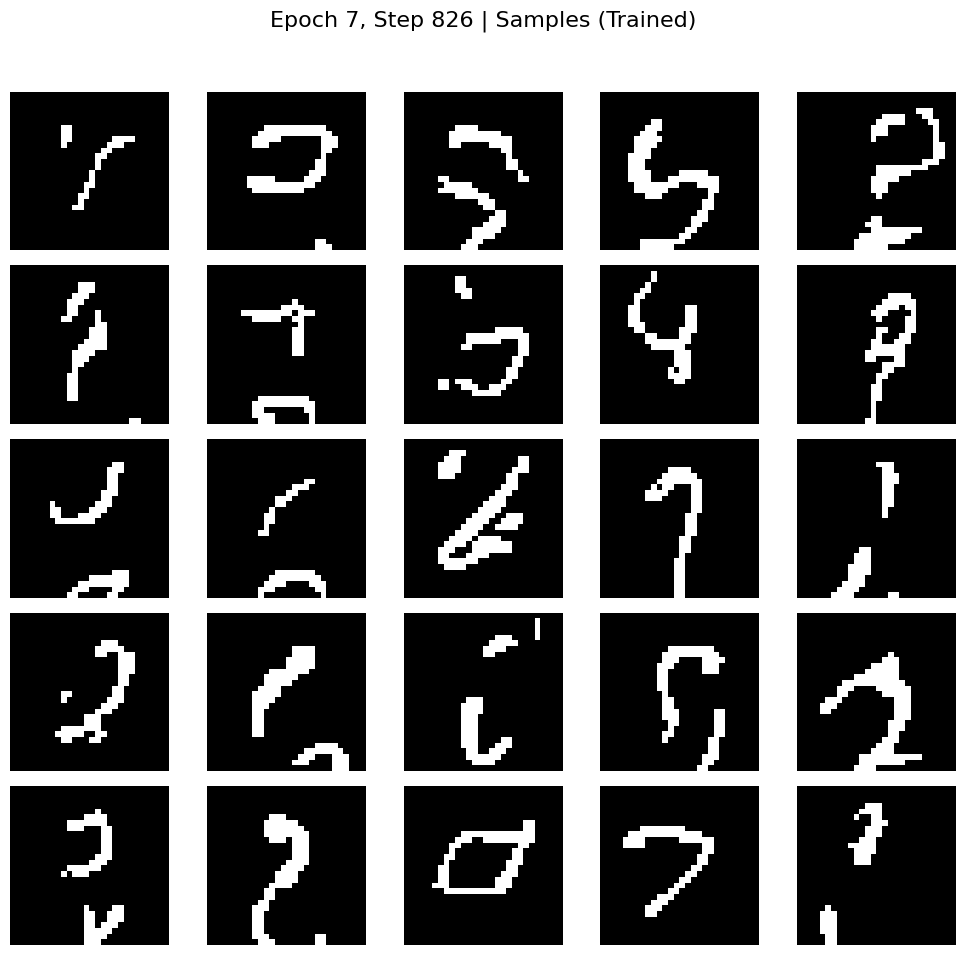

Epoch 7/8 | BINARY: 100%|██████████| 118/118 [01:58<00:00,  1.00s/it, loss=0.0857]


Сэмплы сохранены в generated_images/samples_e7_s826.png
Веса сохранены: checkpoints/checkpoint_epoch_7.pth.tar


Epoch 8/8 | BINARY:  99%|█████████▉| 117/118 [01:51<00:00,  1.06it/s, loss=0.0850]


--- Генерируем сэмплы на шаге 944...


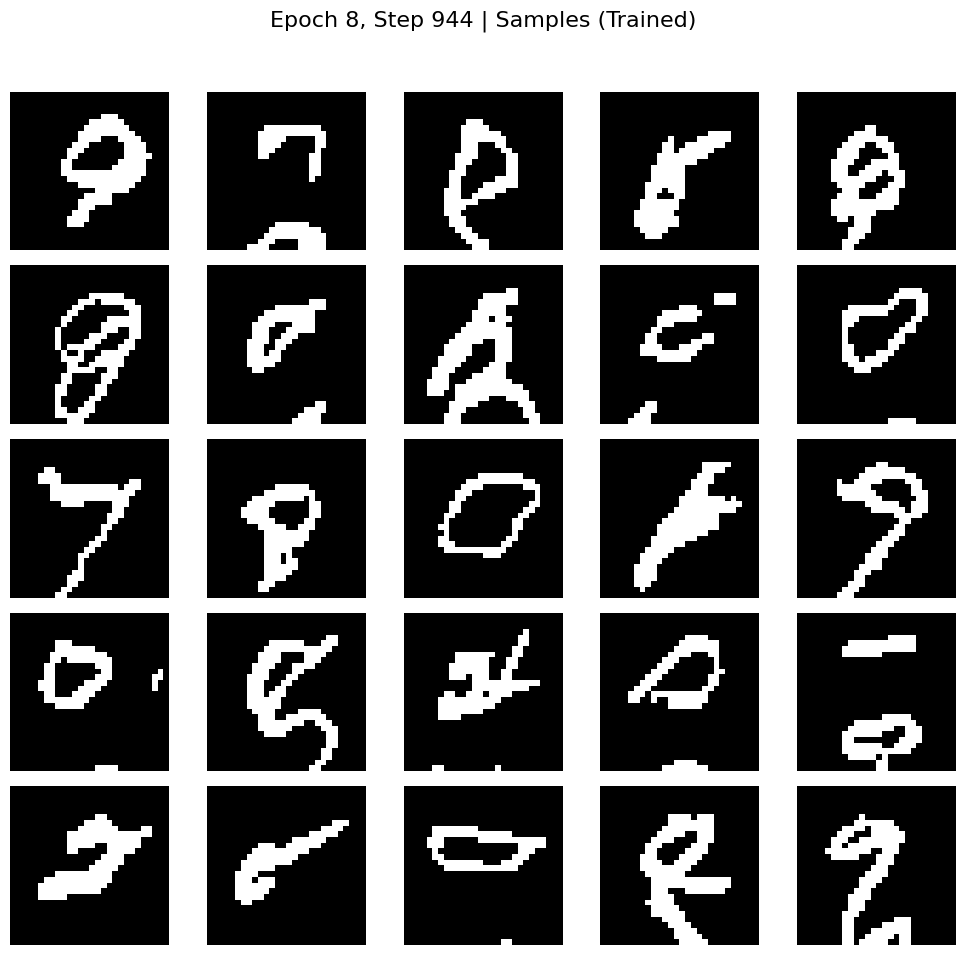

Epoch 8/8 | BINARY: 100%|██████████| 118/118 [01:58<00:00,  1.00s/it, loss=0.0850]

Сэмплы сохранены в generated_images/samples_e8_s944.png
Веса сохранены: checkpoints/checkpoint_epoch_8.pth.tar
Обучение завершено.


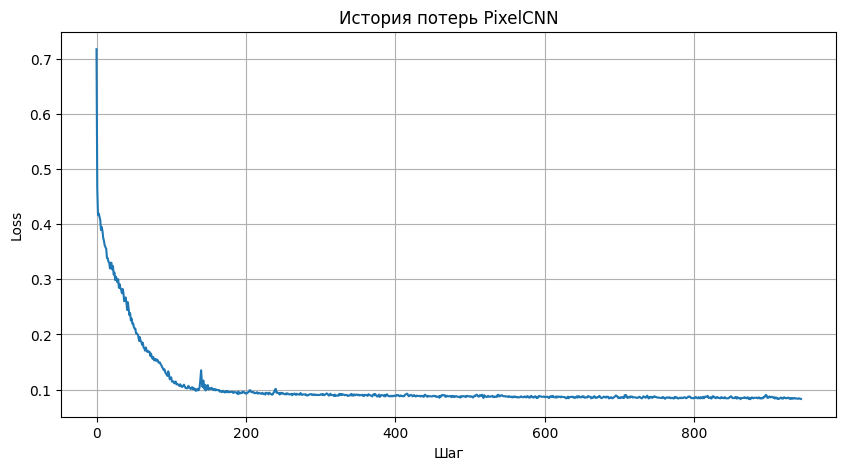

In [22]:
epochs = 8
LR = 1e-3
config = {'mode': 'binary',
          'out_classes': 2,
          }
DEVICE = 'cuda'
loss_history = train_pixelcnn(
    model=model_binary,
    config=config,
    train_loader=train_loader,
    epochs=epochs,
    lr=LR,
    generate_every=118
)

# Визуализация истории потерь (опционально)
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("История потерь PixelCNN")
plt.xlabel("Шаг")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [23]:
samples = model_binary.sample(15)


--- Результаты сэмплирования ---
Форма сэмплов: (15, 1, 28, 28)
Диапазон значений: 0.0 - 1.0


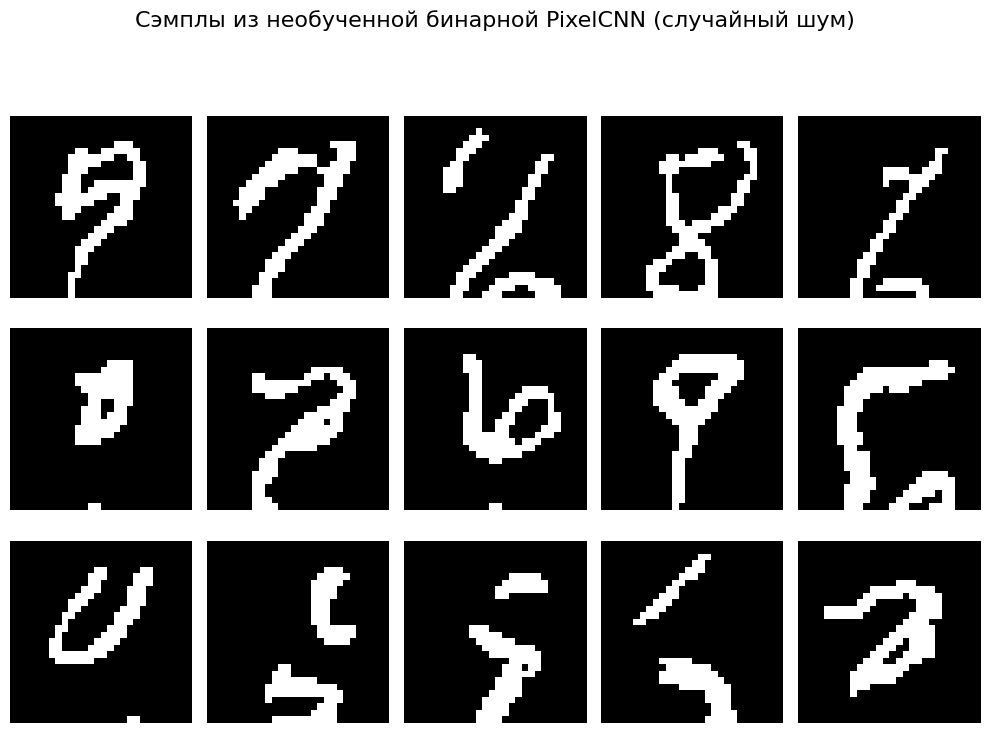

In [24]:
print("\n--- Результаты сэмплирования ---")
print(f"Форма сэмплов: {samples.shape}")
print(f"Диапазон значений: {samples.min()} - {samples.max()}")

# 4. Визуализация
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
fig.suptitle("Сэмплы из необученной бинарной PixelCNN (случайный шум)", fontsize=16)
for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        ax = axes[i, j]
        ax.imshow(samples[idx][0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')

# Уменьшаем отступы между сабплотами для более компактного вида
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [110]:
HIDDEN_CHANNELS = [64, 128, 256, 256, 256]


model_gray = PixelCNN(in_channels=1,
                        out_channels=256,
                        hidden_channels=HIDDEN_CHANNELS,
                        kernel_size=5,
                        device=device)

model_gray = model_gray.to(device)


In [111]:
model_gray

PixelCNN(
  (loss_fn): CrossEntropyLoss()
  (net): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaskedConv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): MaskedConv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): LayerNorm2d((256,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): MaskedConv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): LayerNorm2d((256,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
    (12): MaskedConv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): MaskedConv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [112]:
total_params = sum(p.numel() for p in model_gray.parameters() if p.requires_grad)
print(f"Модель: PixelCNN (gray)")
print(f"Общее количество обучаемых параметров: {total_params:,}")


Модель: PixelCNN (gray)
Общее количество обучаемых параметров: 4,370,560


In [113]:
samples = model_gray.sample(15)


--- Результаты сэмплирования ---
Форма сэмплов: (15, 1, 28, 28)
Диапазон значений: 0.0 - 1.0


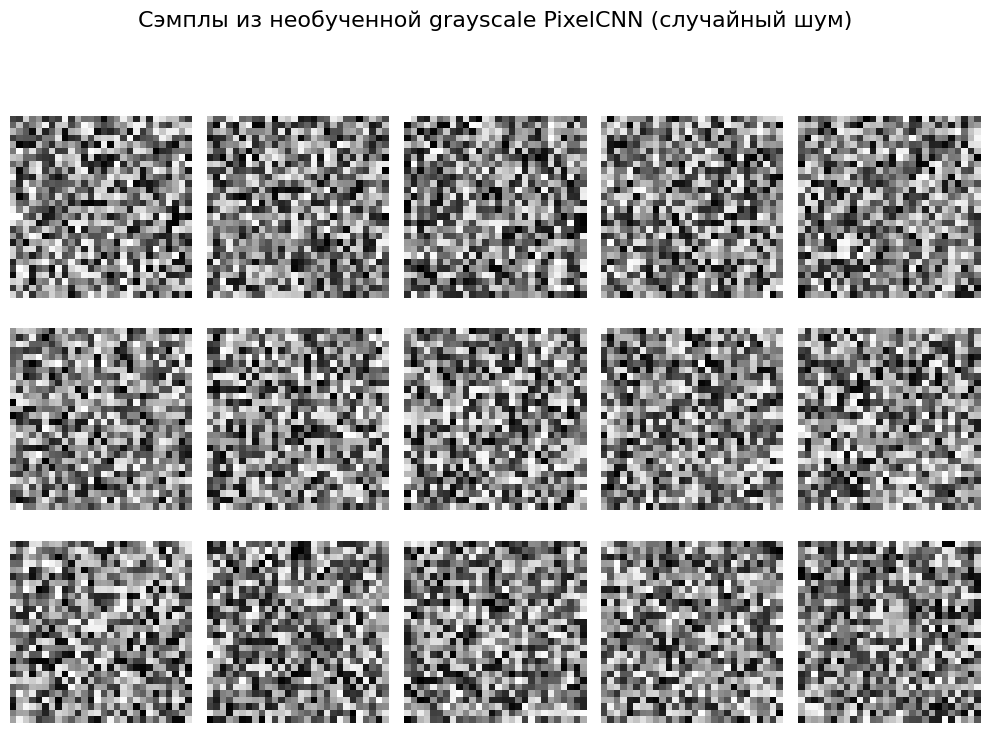

In [102]:
print("\n--- Результаты сэмплирования ---")
print(f"Форма сэмплов: {samples.shape}")
print(f"Диапазон значений: {samples.min()} - {samples.max()}")

# 4. Визуализация
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
fig.suptitle("Сэмплы из необученной grayscale PixelCNN (случайный шум)", fontsize=16)
for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        ax = axes[i, j]
        ax.imshow(samples[idx][0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')

# Уменьшаем отступы между сабплотами для более компактного вида
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Epoch 1/8 | GRAY: 100%|█████████▉| 468/469 [03:55<00:00,  1.99it/s, loss=0.9961]


--- Генерируем сэмплы на шаге 469...


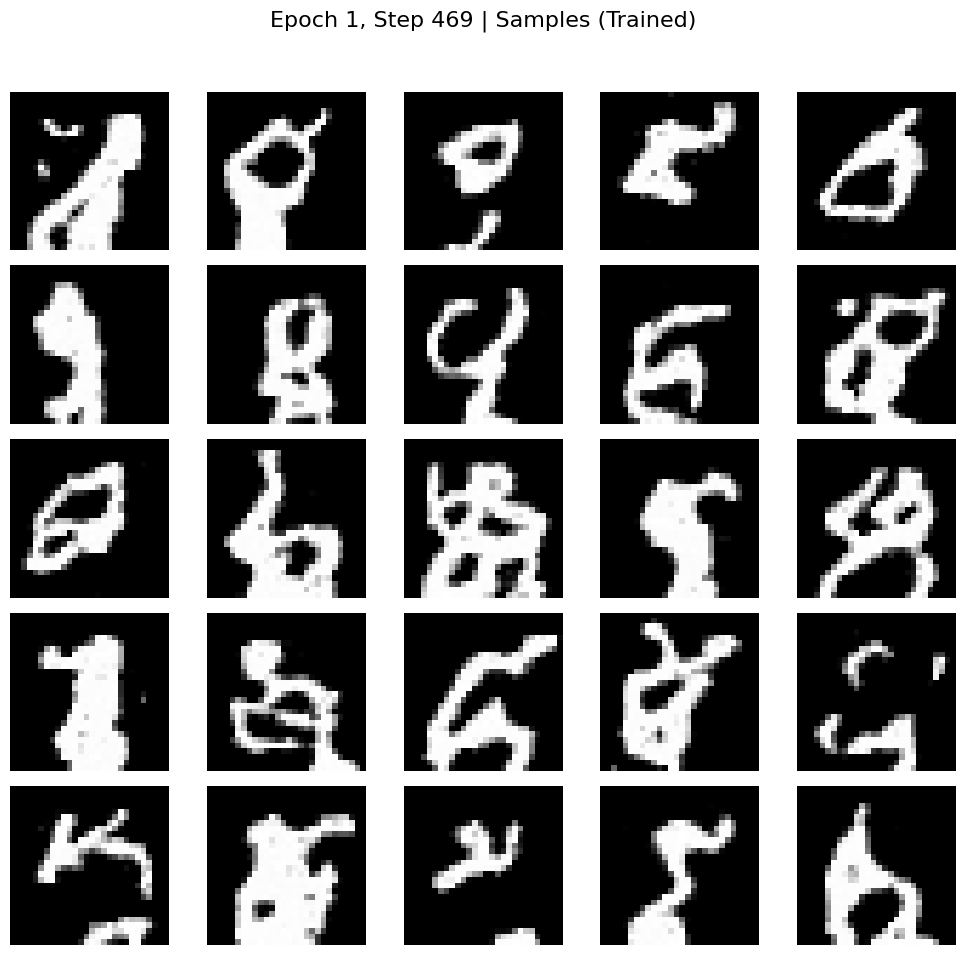

Epoch 1/8 | GRAY: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s, loss=0.9961]


Сэмплы сохранены в generated_images/samples_e1_s469.png
Веса сохранены: checkpoints/checkpoint_epoch_1.pth.tar


Epoch 2/8 | GRAY: 100%|█████████▉| 468/469 [03:57<00:00,  1.98it/s, loss=0.7977]


--- Генерируем сэмплы на шаге 938...


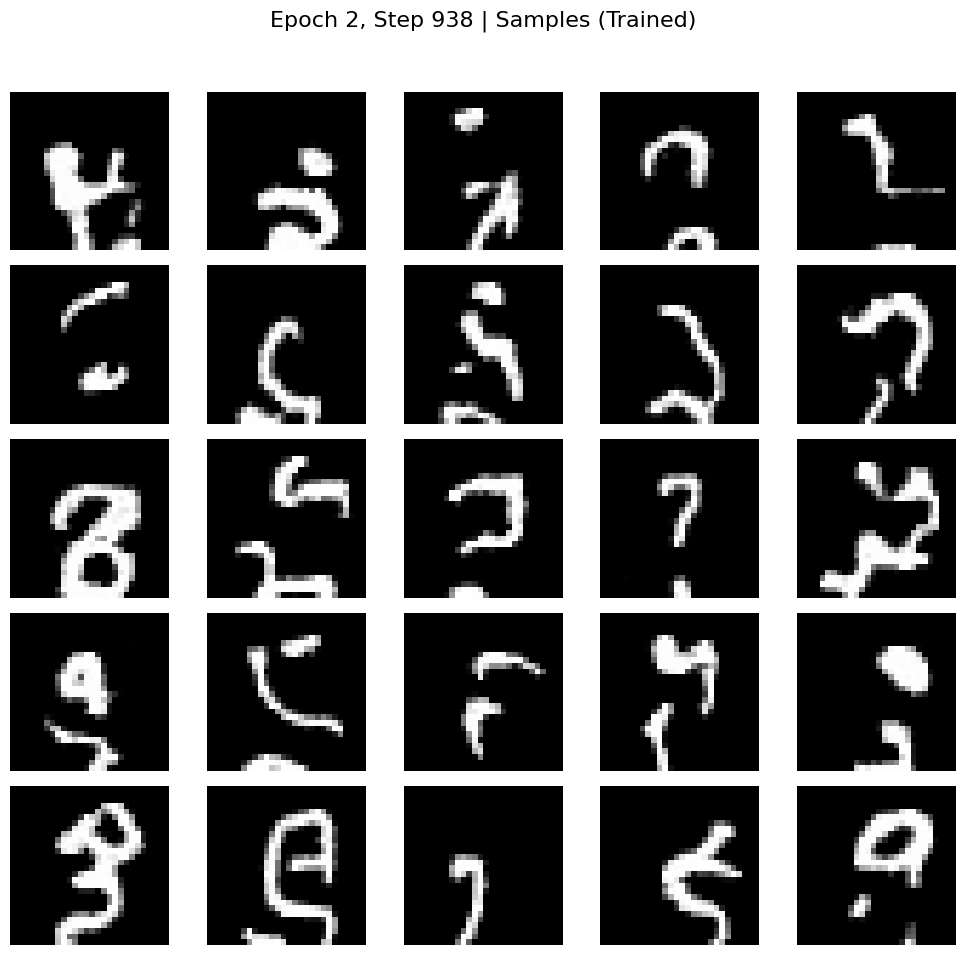

Epoch 2/8 | GRAY: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s, loss=0.7977]


Сэмплы сохранены в generated_images/samples_e2_s938.png
Веса сохранены: checkpoints/checkpoint_epoch_2.pth.tar


Epoch 3/8 | GRAY: 100%|█████████▉| 468/469 [03:57<00:00,  1.96it/s, loss=0.7813]


--- Генерируем сэмплы на шаге 1407...


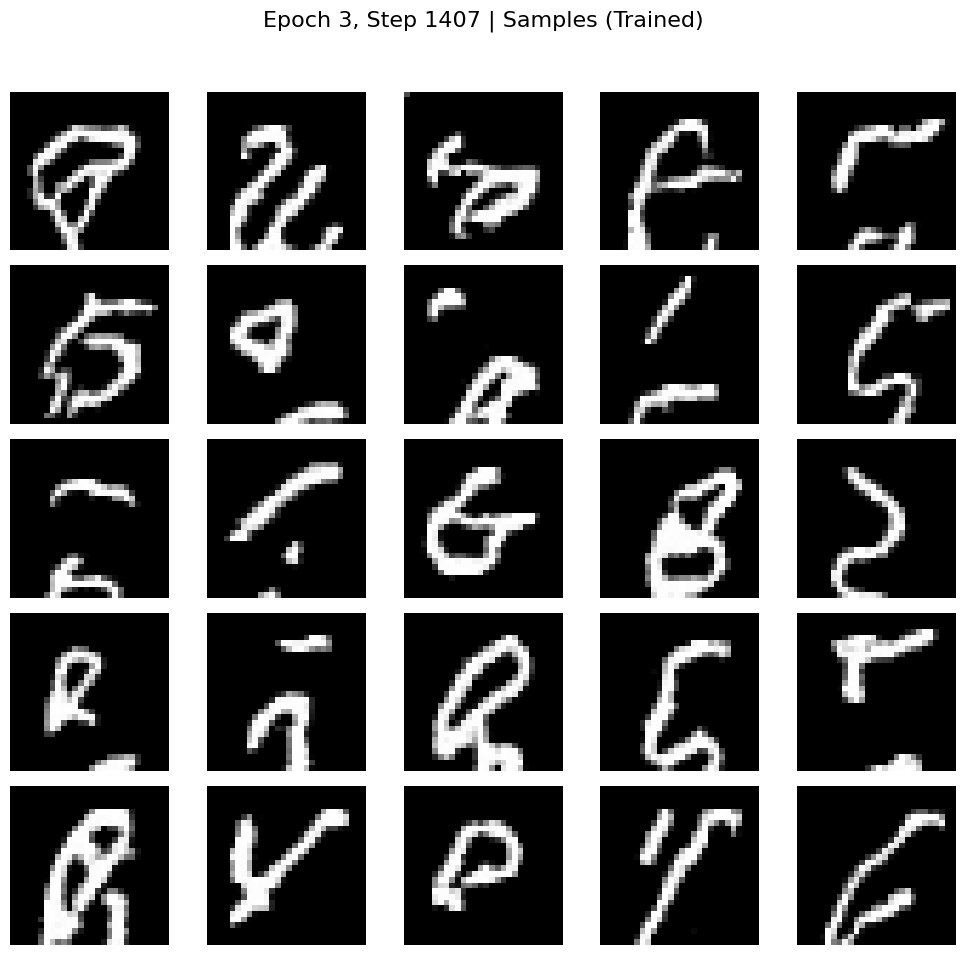

Epoch 3/8 | GRAY: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s, loss=0.7813]


Сэмплы сохранены в generated_images/samples_e3_s1407.png
Веса сохранены: checkpoints/checkpoint_epoch_3.pth.tar


Epoch 4/8 | GRAY: 100%|█████████▉| 468/469 [03:56<00:00,  1.99it/s, loss=0.8725]


--- Генерируем сэмплы на шаге 1876...


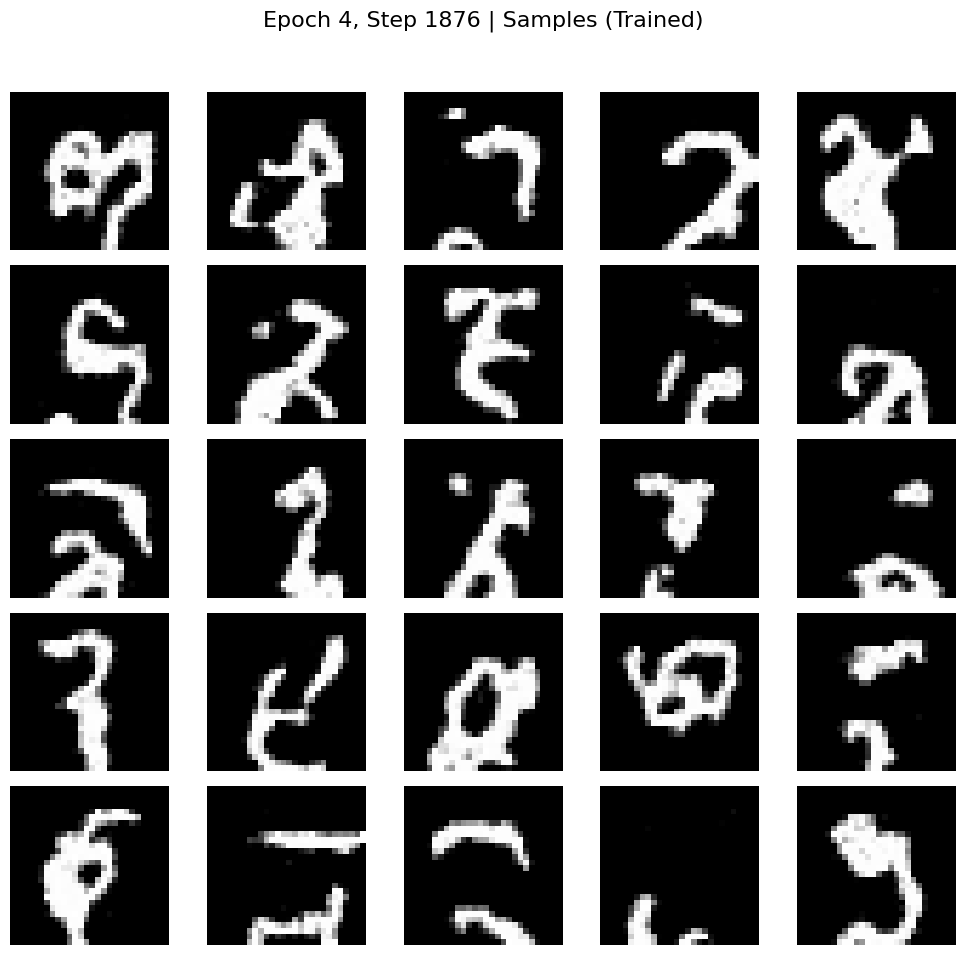

Epoch 4/8 | GRAY: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s, loss=0.8725]


Сэмплы сохранены в generated_images/samples_e4_s1876.png
Веса сохранены: checkpoints/checkpoint_epoch_4.pth.tar


Epoch 5/8 | GRAY: 100%|█████████▉| 468/469 [03:56<00:00,  1.99it/s, loss=0.8099]


--- Генерируем сэмплы на шаге 2345...


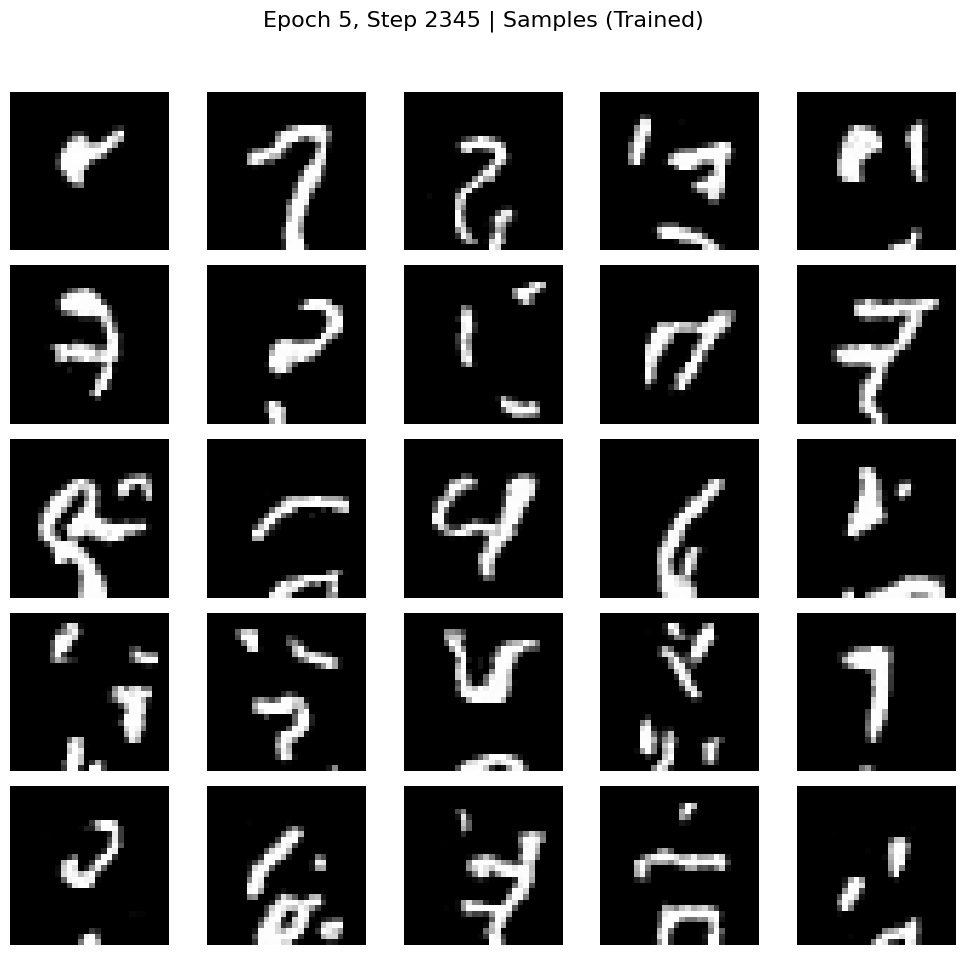

Epoch 5/8 | GRAY: 100%|██████████| 469/469 [04:09<00:00,  1.88it/s, loss=0.8099]


Сэмплы сохранены в generated_images/samples_e5_s2345.png
Веса сохранены: checkpoints/checkpoint_epoch_5.pth.tar


Epoch 6/8 | GRAY: 100%|█████████▉| 468/469 [03:57<00:00,  1.98it/s, loss=0.7916]


--- Генерируем сэмплы на шаге 2814...


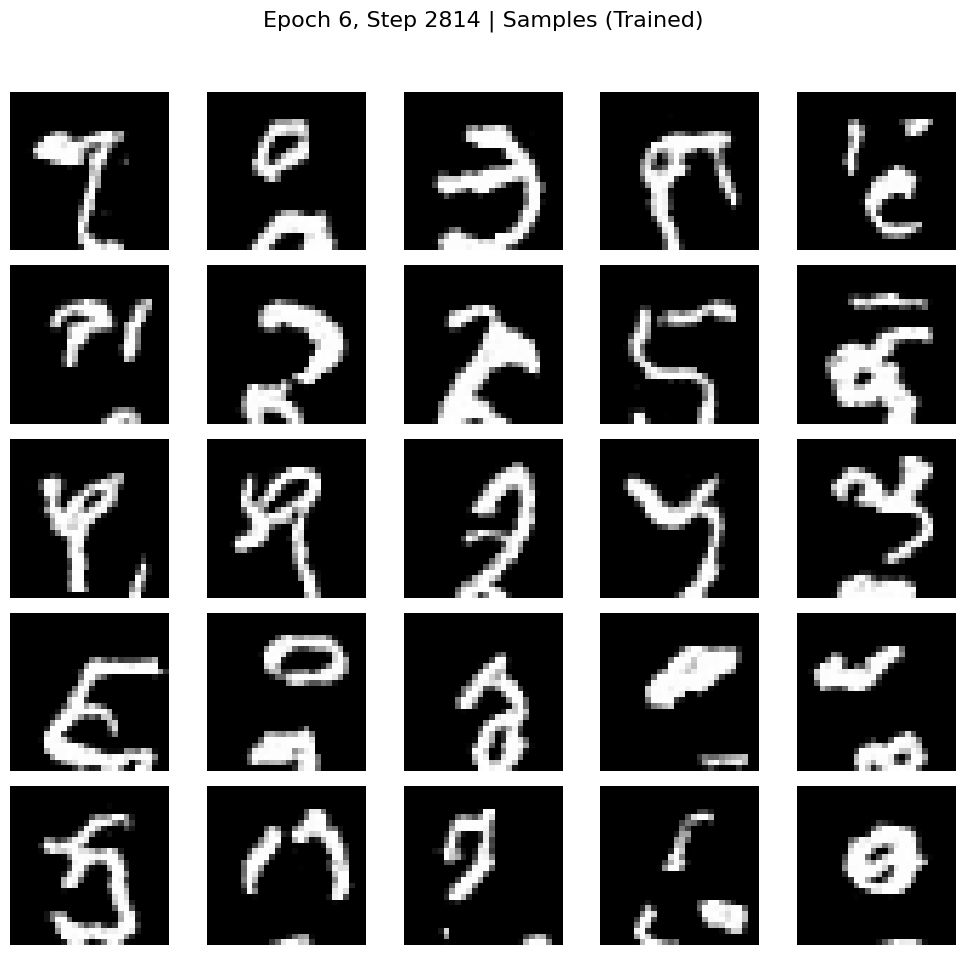

Epoch 6/8 | GRAY: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s, loss=0.7916]


Сэмплы сохранены в generated_images/samples_e6_s2814.png
Веса сохранены: checkpoints/checkpoint_epoch_6.pth.tar


Epoch 7/8 | GRAY: 100%|█████████▉| 468/469 [03:56<00:00,  1.97it/s, loss=0.7819]


--- Генерируем сэмплы на шаге 3283...


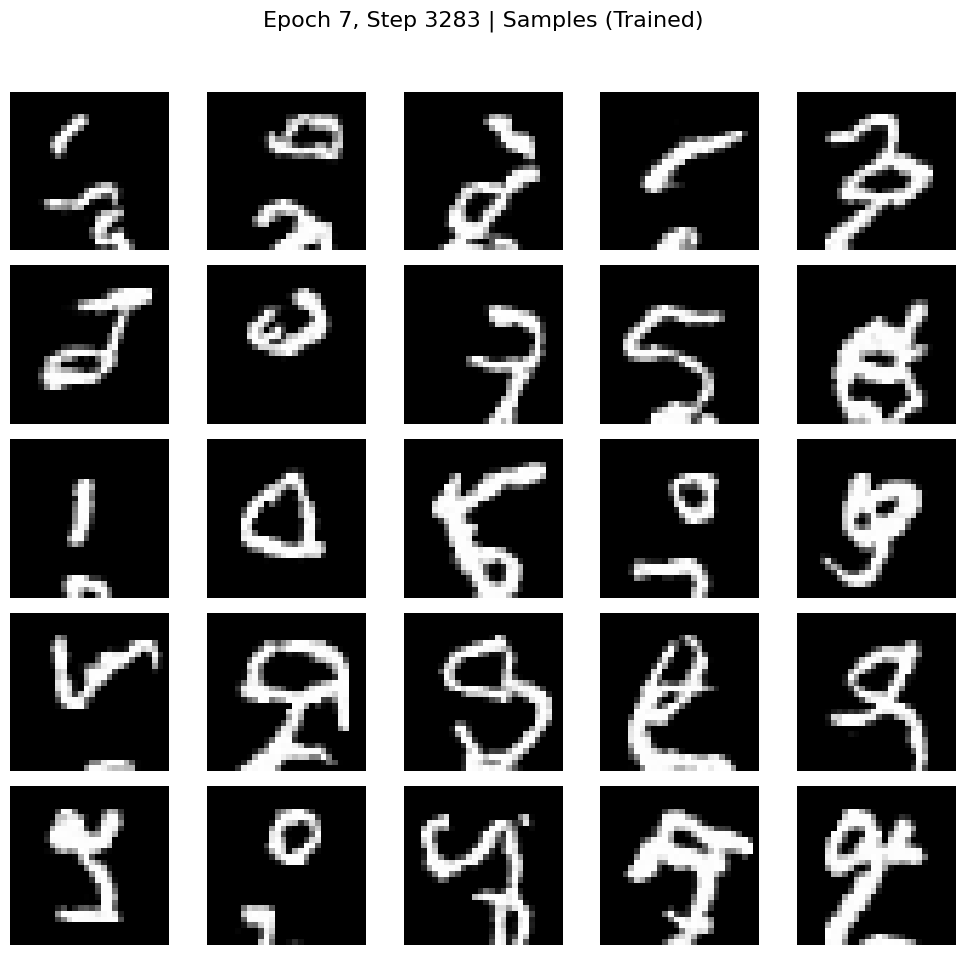

Epoch 7/8 | GRAY: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s, loss=0.7819]


Сэмплы сохранены в generated_images/samples_e7_s3283.png
Веса сохранены: checkpoints/checkpoint_epoch_7.pth.tar


Epoch 8/8 | GRAY: 100%|█████████▉| 468/469 [03:56<00:00,  1.99it/s, loss=0.7756]


--- Генерируем сэмплы на шаге 3752...


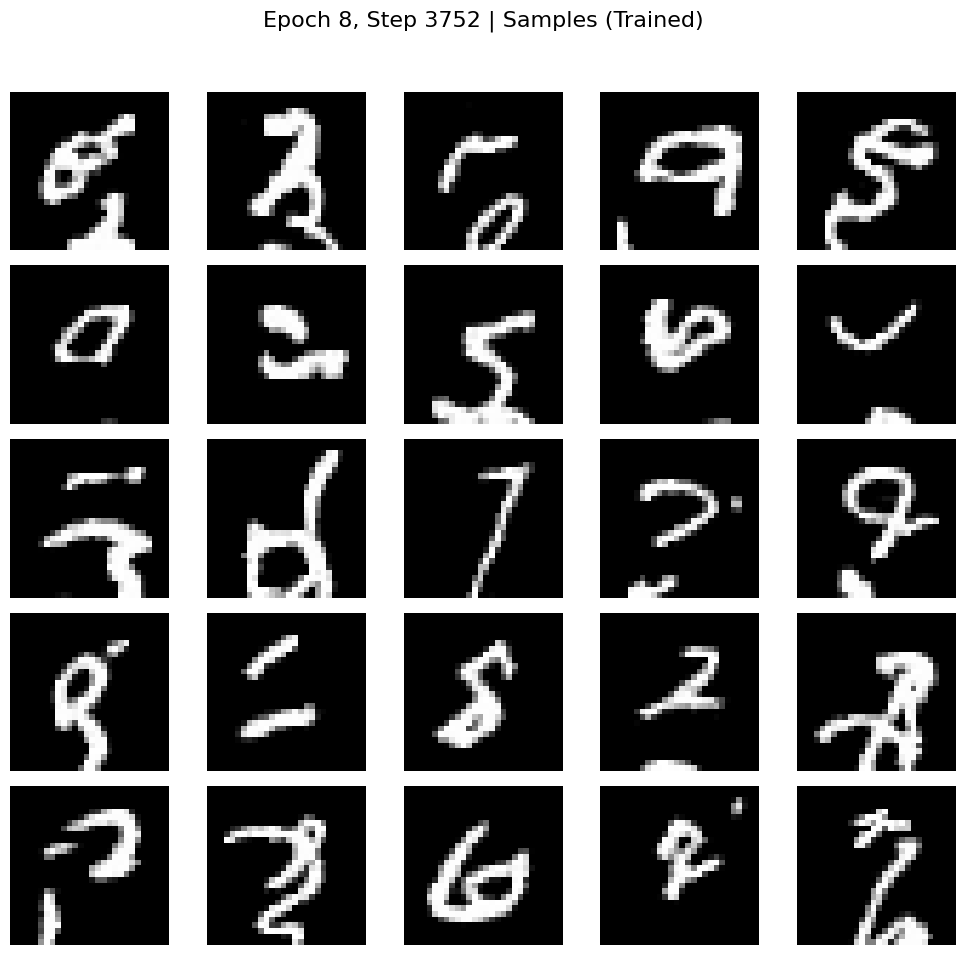

Epoch 8/8 | GRAY: 100%|██████████| 469/469 [04:11<00:00,  1.87it/s, loss=0.7756]

Сэмплы сохранены в generated_images/samples_e8_s3752.png
Веса сохранены: checkpoints/checkpoint_epoch_8.pth.tar
Обучение завершено.


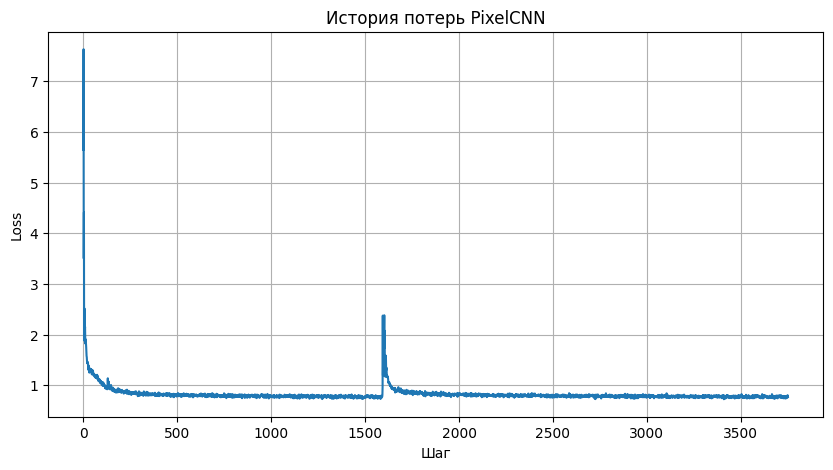

In [114]:
epochs = 8
LR =5e-3
config = {'mode': 'gray',
          'out_classes': 256,
          }
DEVICE = 'cuda'
loss_history = train_pixelcnn(
    model=model_gray,
    config=config,
    train_loader=train_loader_gray,
    epochs=epochs,
    lr=LR,
    generate_every=469
)

# Визуализация истории потерь (опционально)
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("История потерь PixelCNN")
plt.xlabel("Шаг")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [115]:
samples = model_gray.sample(15)


--- Результаты сэмплирования ---
Форма сэмплов: (15, 1, 28, 28)
Диапазон значений: 0.0 - 1.0


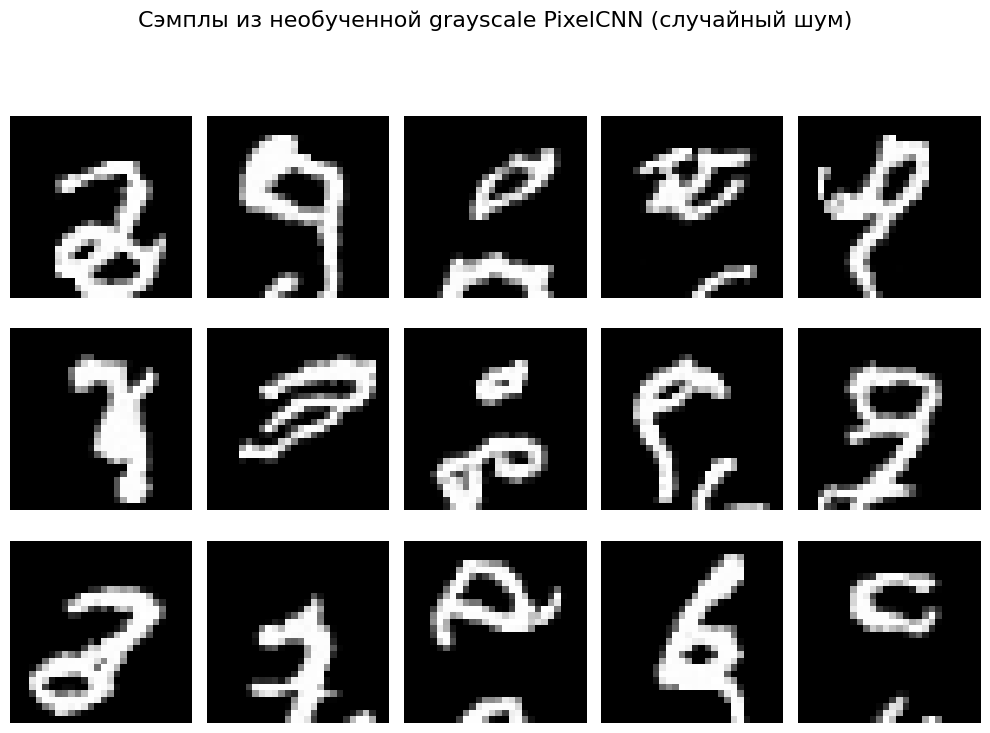

In [116]:
print("\n--- Результаты сэмплирования ---")
print(f"Форма сэмплов: {samples.shape}")
print(f"Диапазон значений: {samples.min()} - {samples.max()}")

# 4. Визуализация
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
fig.suptitle("Сэмплы из необученной grayscale PixelCNN (случайный шум)", fontsize=16)
for i in range(3):
    for j in range(5):
        idx = i * 5 + j
        ax = axes[i, j]
        ax.imshow(samples[idx][0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')

# Уменьшаем отступы между сабплотами для более компактного вида
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()